# Arabic Dialect Classification with Explainable AI

This notebook loads a pre-trained Arabic dialect classification model and applies explainable AI techniques (LIME and SHAP) to understand the model's predictions.

## 1. Setup and Dependencies

In [ ]:
# Install required packages for Arabic support
#!pip install arabic-reshaper python-bidi

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import os
import matplotlib
from matplotlib import font_manager
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lime
import lime.lime_text
import shap
import seaborn as sns
from tqdm.notebook import tqdm

# Import Arabic text support libraries
import arabic_reshaper
from bidi.algorithm import get_display

# Configure matplotlib for Arabic
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Amiri', 'sans-serif']

# Function to properly display Arabic text in plots
def display_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## 2. Load Pre-trained Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model and tokenizer
model_path = "arabic_dialect_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)

# Load dialect mappings
with open(os.path.join(model_path, "dialect_mappings.json"), "r", encoding="utf-8") as f:
    mappings = json.load(f)
    
dialect_to_id = mappings["dialect_to_id"]
id_to_dialect = mappings["id_to_dialect"]

# Convert id_to_dialect keys to integers
id_to_dialect = {int(k): v for k, v in id_to_dialect.items()}

print(f"Loaded model with {len(dialect_to_id)} dialects")

Using device: cpu
Loaded model with 26 dialects


## 3. Define Prediction Functions

In [3]:
# Define prediction function
def predict_dialect(text):
    """Predict the dialect of a given text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        
    return id_to_dialect[pred_label], probs[0].cpu().numpy()

# Function to predict multiple texts
def predict_batch(texts):
    """Predict dialects for a batch of texts"""
    predictions = []
    probabilities = []
    
    for text in tqdm(texts, desc="Predicting"):
        dialect, probs = predict_dialect(text)
        predictions.append(dialect)
        probabilities.append(probs)
        
    return predictions, np.array(probabilities)

## 4. Load and Prepare Data

In [4]:
# Load data
df = pd.read_csv("MADAR_Corpus_Combined.csv")
df = df.dropna(subset=["lang", "sent"])

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (112000, 3)


,split,lang,sent
0,corpus-6-dev,TUN,وريني جدول الاوقات، يعيشك.
1,corpus-6-test-corpus-26-train,ASW,معندكش دروس تجريبية؟
2,corpus-6-train,RAB,اه، مزيان.
3,corpus-6-train,DOH,اظن الرقم غلط.
4,corpus-6-train,CAI,مسار الخير، فندق النجمة. أي خدمة؟


In [5]:
# Sample some test data (for demonstration)
test_df = df.sample(n=100, random_state=42)
test_texts = test_df["sent"].tolist()
test_labels = test_df["lang"].tolist()

# Predict dialects for test data
print("Predicting dialects for test data...")
pred_dialects, probabilities = predict_batch(test_texts)

Predicting dialects for test data...


Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

## 5. Evaluate Model Performance

In [6]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, pred_dialects)
print(f"Accuracy on test data: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, pred_dialects))

Accuracy on test data: 0.8400

Classification Report:
              precision    recall  f1-score   support

         ALE       1.00      1.00      1.00         1
         ALG       1.00      1.00      1.00         2
         ALX       1.00      0.75      0.86         4
         AMM       0.00      0.00      0.00         3
         ASW       1.00      0.50      0.67         2
         BAG       1.00      0.50      0.67         2
         BAS       0.75      1.00      0.86         3
         BEI       0.67      1.00      0.80         6
         BEN       1.00      1.00      1.00         1
         CAI       0.75      1.00      0.86        12
         DAM       0.00      0.00      0.00         1
         DOH       0.93      1.00      0.97        14
         FES       1.00      1.00      1.00         2
         JED       1.00      1.00      1.00         2
         JER       0.50      0.50      0.50         2
         MOS       1.00      1.00      1.00         2
         MSA       1.00    

d:\A_Z_NLP\End-To-End-Project\GEN_AI_Projects\finalenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\A_Z_NLP\End-To-End-Project\GEN_AI_Projects\finalenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\A_Z_NLP\End-To-End-Project\GEN_AI_Projects\finalenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

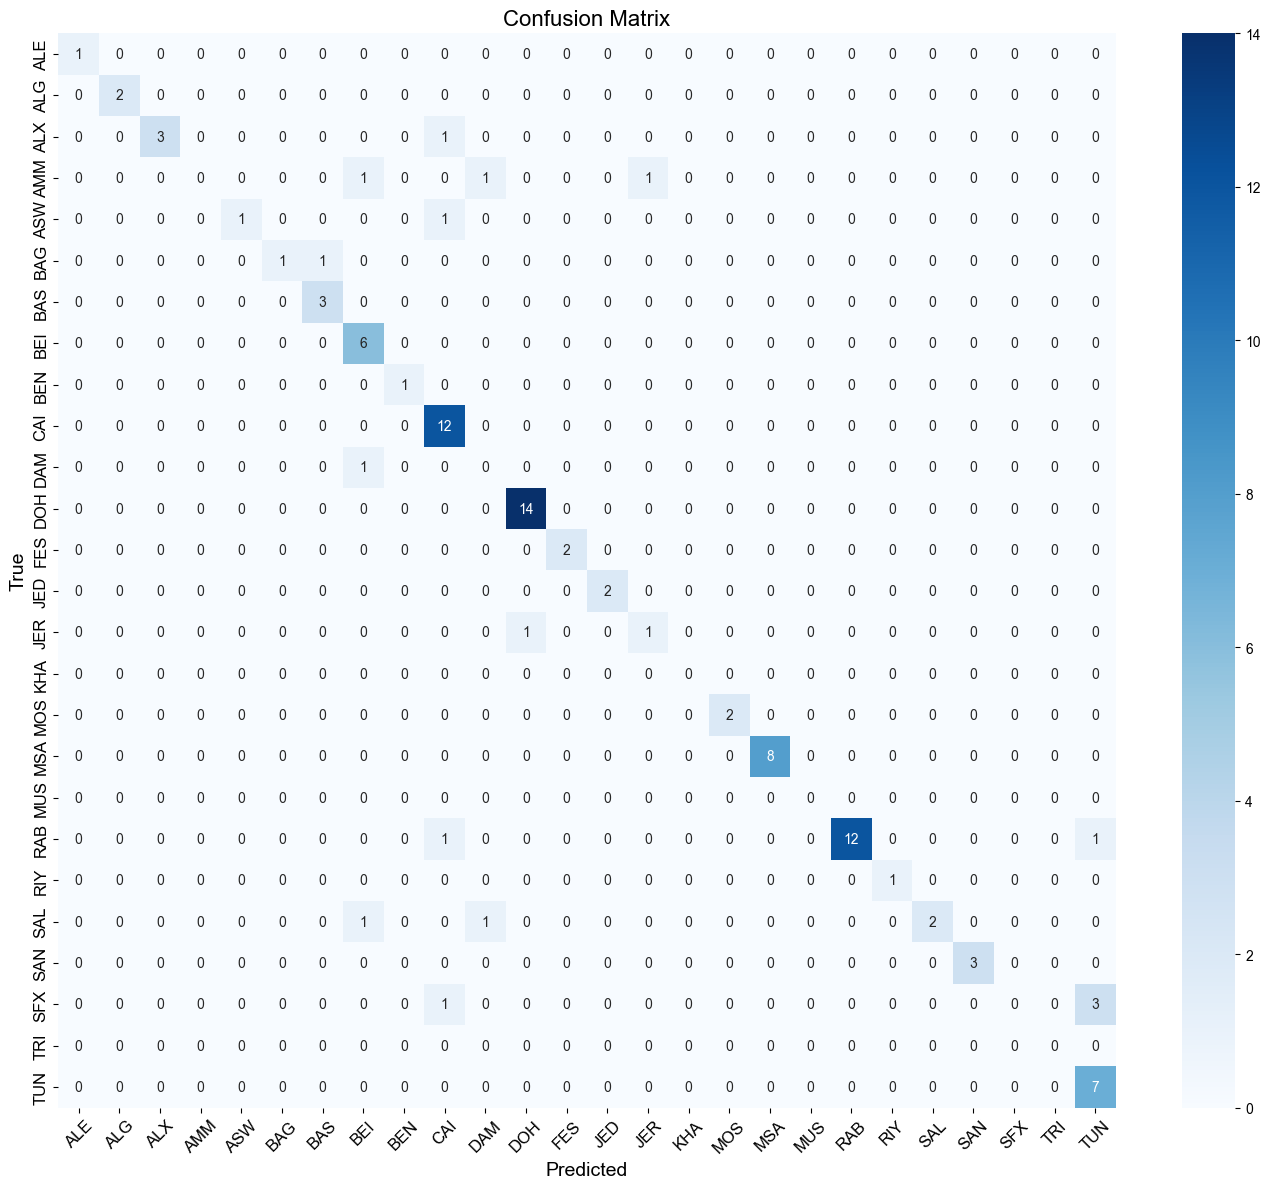

In [7]:
# Plot confusion matrix with Arabic support
plt.figure(figsize=(14, 12))
cm = confusion_matrix(test_labels, pred_dialects, labels=list(dialect_to_id.keys()))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(dialect_to_id.keys()), 
            yticklabels=list(dialect_to_id.keys()))
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 6. Select Examples for Explanation

In [8]:
# Select a few examples for LIME and SHAP explanations
sample_indices = [0, 10, 20, 30, 40]
sample_texts = [test_texts[i] for i in sample_indices]
sample_true_dialects = [test_labels[i] for i in sample_indices]
sample_pred_dialects = [pred_dialects[i] for i in sample_indices]

print("\nSample texts for explanations:")
for i, (text, true, pred) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true}")
    print(f"Predicted dialect: {pred}")
    print()


Sample texts for explanations:
Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS



## 7. LIME Explanations

LIME (Local Interpretable Model-agnostic Explanations) helps us understand which parts of the text contribute most to a specific prediction.

In [15]:
# Create a prediction function for LIME
def predict_proba_fn(texts):
    """Prediction function for LIME"""
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    
    return probs.cpu().numpy()

# Initialize LIME text explainer
explainer = lime.lime_text.LimeTextExplainer(class_names=list(dialect_to_id.keys()))


LIME explanation for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Features contributing to prediction:
ميا: 0.4995
بيت: 0.1192
كيدا: 0.0834
انا: -0.0529
في: 0.0454
تسعة: -0.0234
و: 0.0147
عشرين: 0.0098
سبعة: 0.0068


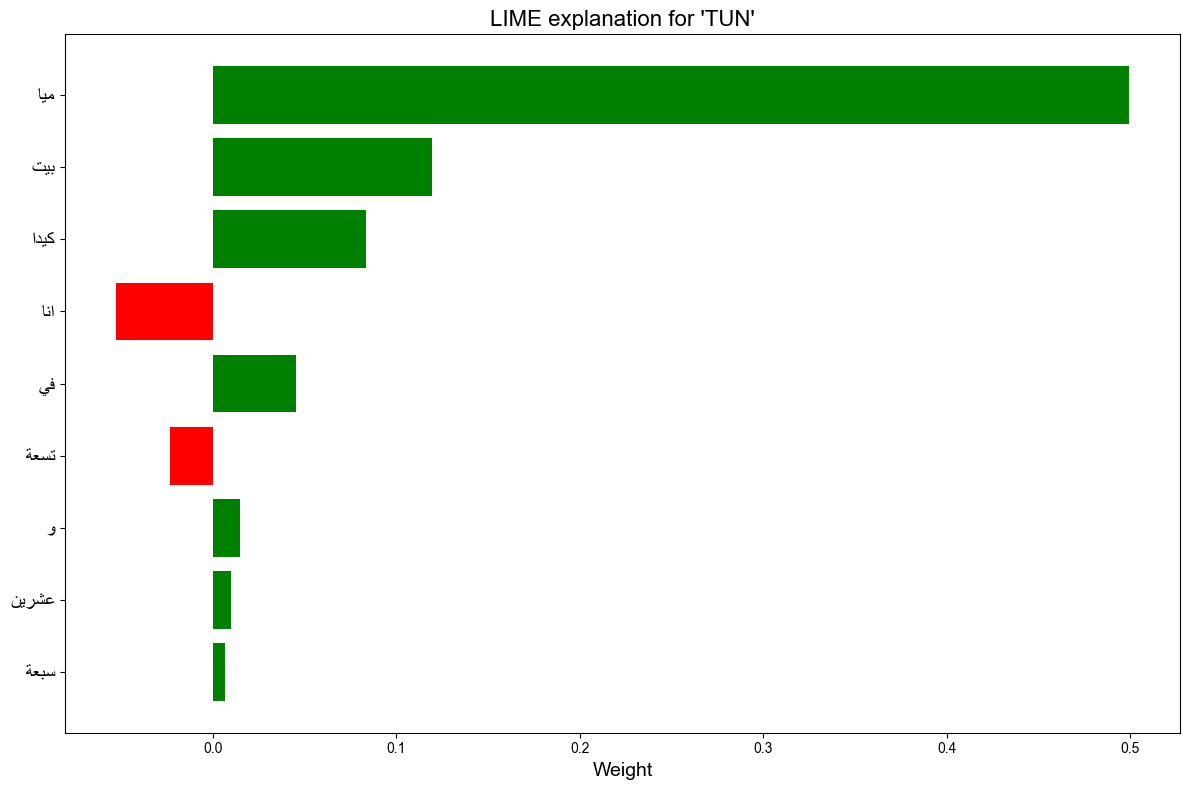


LIME explanation for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Features contributing to prediction:
دة: 0.1699
فى: 0.1179
قوللى: 0.1148
فضلك: 0.0202
من: 0.0090
كويس: 0.0085
موقع: 0.0079
النهر: 0.0065


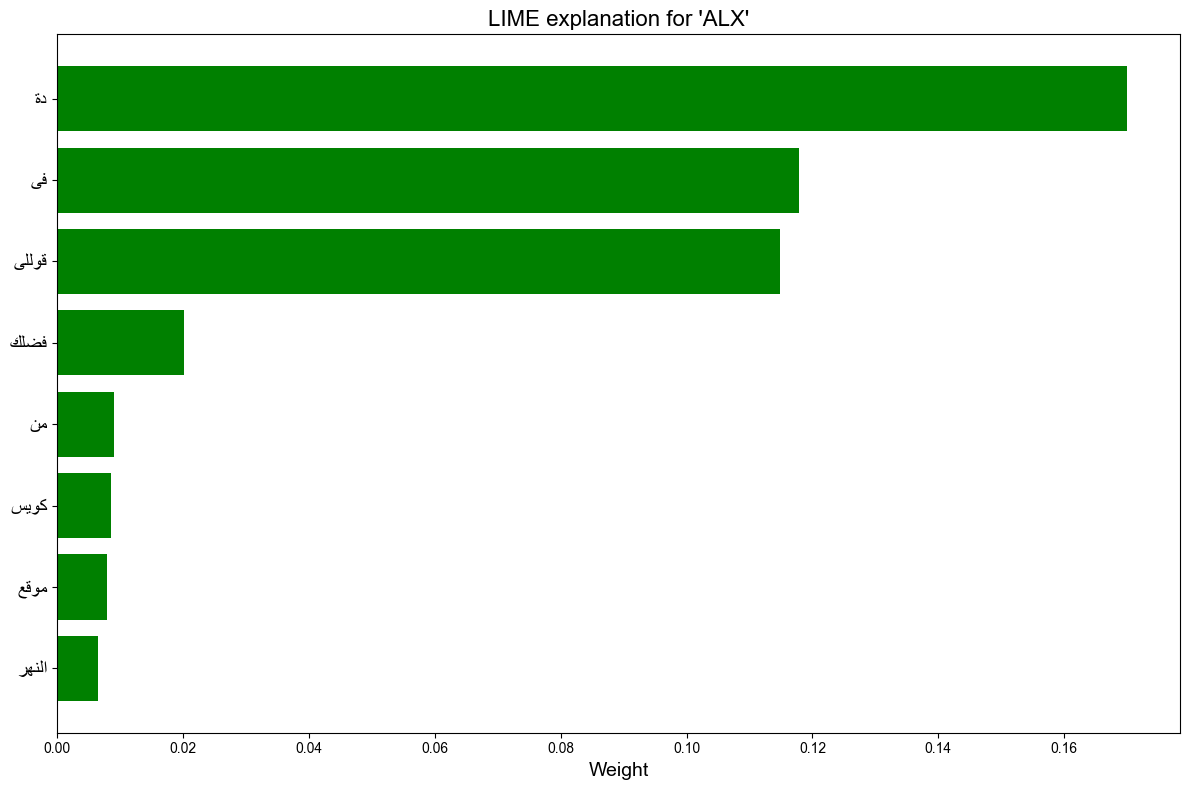


LIME explanation for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Features contributing to prediction:
مرة: 0.4458
حتشيك: 0.2128
استخدمت: 0.1901
دا: 0.1624
ما: -0.1015
عندك: 0.0482
انا: 0.0389
خدمة: -0.0282
الغسيل: 0.0119
تانية: 0.0012


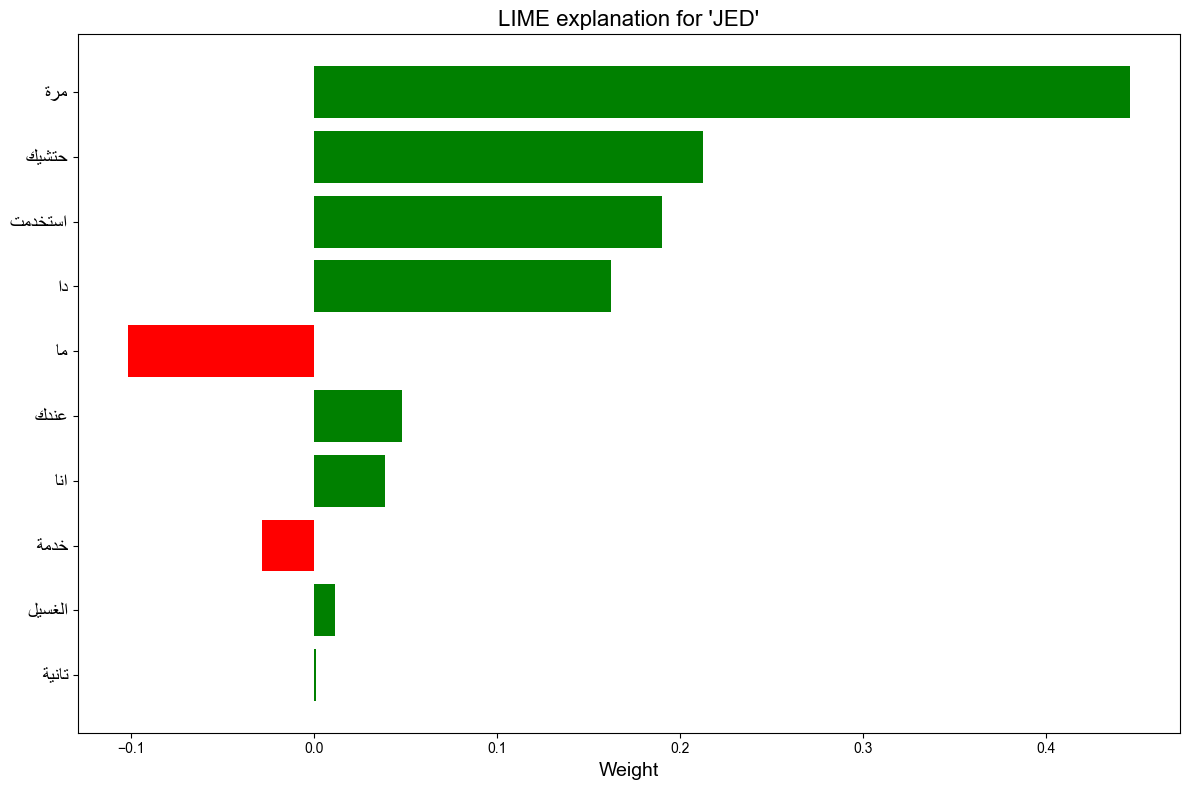


LIME explanation for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Features contributing to prediction:
خل: 0.0657
الشناط: 0.0634
ثلاث: 0.0564
لي: 0.0299
سمحت: 0.0272
لو: 0.0041


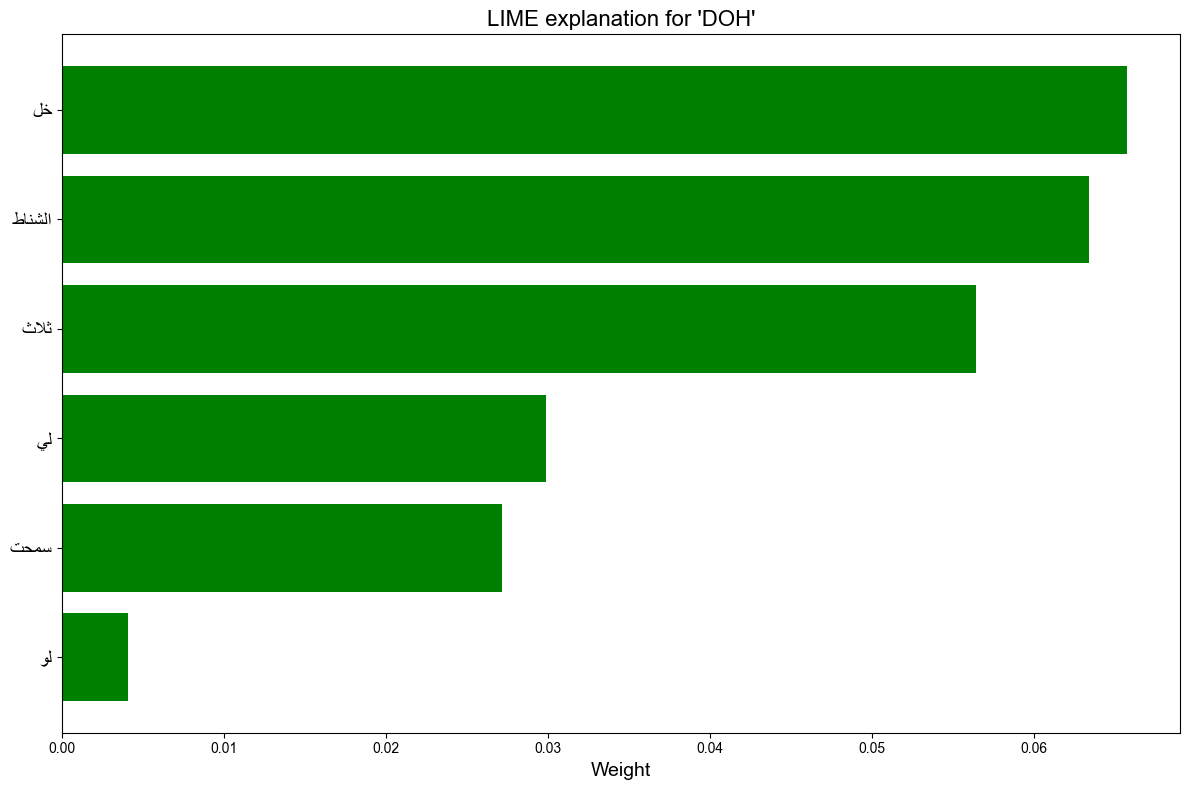


LIME explanation for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS

Features contributing to prediction:
اطول: 0.3301
شوي: 0.1362
عندي: 0.1130
شي: 0.0632
اي: 0.0199


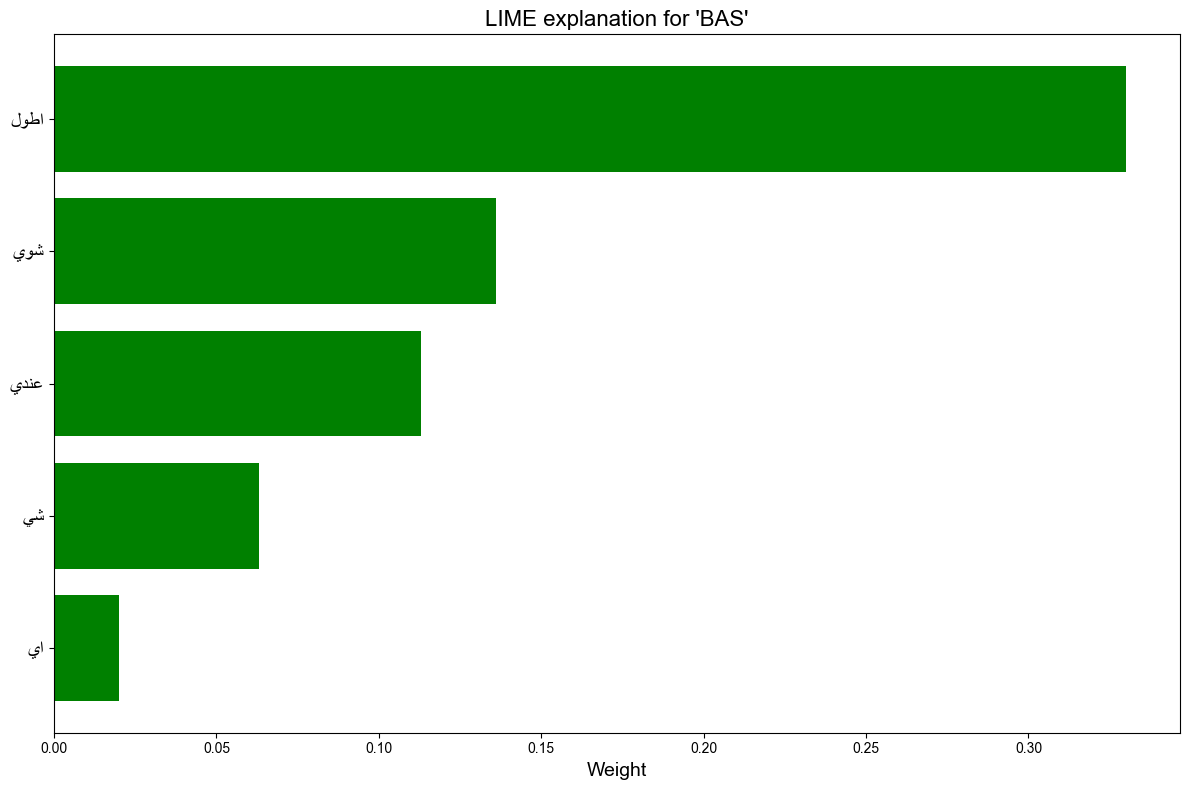

In [16]:
# Generate LIME explanations for each sample
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nLIME explanation for Example {i+1}:")
    
    # Get the predicted class index
    pred_idx = dialect_to_id[pred_dialect]
    
    # Generate explanation
    exp = explainer.explain_instance(text, predict_proba_fn, num_features=10, labels=[pred_idx])
    
    # Print explanation
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Show the explanation
    print("\nFeatures contributing to prediction:")
    for feature, weight in exp.as_list(label=pred_idx):
        print(f"{feature}: {weight:.4f}")
    
    # Plot the explanation with Arabic support
    plt.figure(figsize=(12, 8))
    # Get the explanation data
    exp_data = exp.as_list(label=pred_idx)
    features = [x[0] for x in exp_data]
    weights = [x[1] for x in exp_data]
    
    # Sort by absolute weight
    sorted_idx = np.argsort(np.abs(weights))
    features = [features[i] for i in sorted_idx]
    weights = [weights[i] for i in sorted_idx]
    
    # Create horizontal bar chart
    colors = ['red' if w < 0 else 'green' for w in weights]
    plt.barh(range(len(features)), weights, color=colors)
    plt.yticks(range(len(features)), [display_arabic(f) for f in features], fontsize=14)
    plt.xlabel('Weight', fontsize=14)
    plt.title(f"LIME explanation for '{pred_dialect}'", fontsize=16)
    plt.tight_layout()
    plt.show()

## 8. SHAP-like Explanations

SHAP (SHapley Additive exPlanations) provides another approach to explain model predictions by assigning importance values to each feature.

In [12]:
# Create a model wrapper for SHAP that works with text data
class BertModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def __call__(self, texts):
        # Handle both string and list inputs
        if isinstance(texts, str):
            texts = [texts]
            
        # Tokenize the texts
        encoded_texts = []
        for text in texts:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded_texts.append(encoded)
        
        # Get model predictions
        outputs = []
        for encoded in encoded_texts:
            input_ids = encoded['input_ids'].to(self.device)
            attention_mask = encoded['attention_mask'].to(self.device)
            
            with torch.no_grad():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits
                outputs.append(logits.cpu().numpy()[0])
                
        return np.array(outputs)

In [13]:
# Create a custom explainer function for SHAP
def explain_with_shap(text, model_wrapper, tokenizer, pred_idx):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Create a mapping from tokens to words
    word_tokens = []
    current_word = ""
    for token in tokens:
        if token.startswith('##'):
            current_word += token[2:]
        else:
            if current_word:
                word_tokens.append(current_word)
            current_word = token
    if current_word:
        word_tokens.append(current_word)
    
    # Create a baseline (empty text)
    baseline = ""
    
    # Calculate importance for each word
    importances = []
    for i, word in enumerate(word_tokens):
        # Create a masked version without this word
        masked_text = text.replace(word, "")
        
        # Get predictions for original and masked text
        original_pred = model_wrapper(text)[0][pred_idx]
        masked_pred = model_wrapper(masked_text)[0][pred_idx]
        
        # Calculate importance
        importance = original_pred - masked_pred
        importances.append((word, importance))
    
    return importances


SHAP-like explanation for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Words contributing to prediction:
ميا: 2.7730
كيدا: 0.2803
سبعة: 0.2558
انا: -0.1462
عشرين: -0.0624
بيت: -0.0404
في: 0.0332
و: 0.0283
و: 0.0283
.: -0.0083


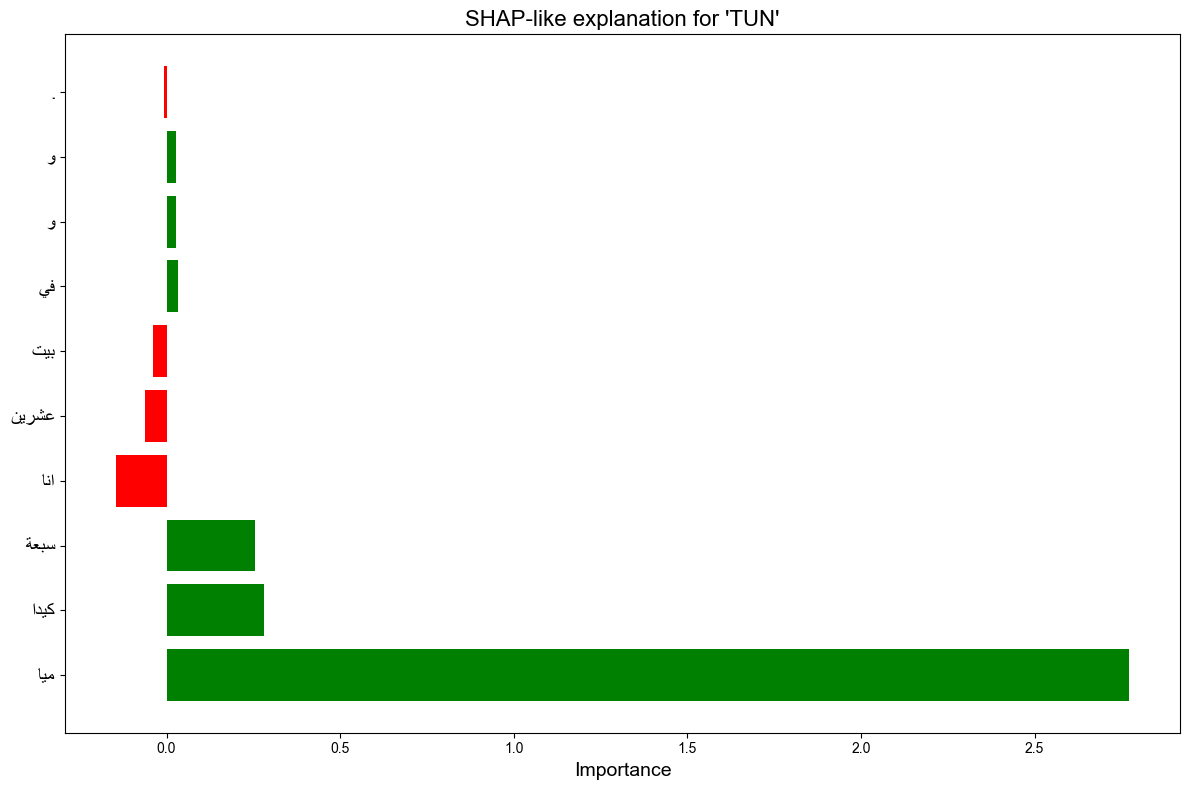


SHAP-like explanation for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Words contributing to prediction:
كويس: 0.1665
قوللى: 0.1243
فضلك: -0.0947
من: -0.0759
دة: -0.0734
النهر: -0.0525
.: -0.0353
موقع: 0.0353
،: 0.0344
فى: 0.0009


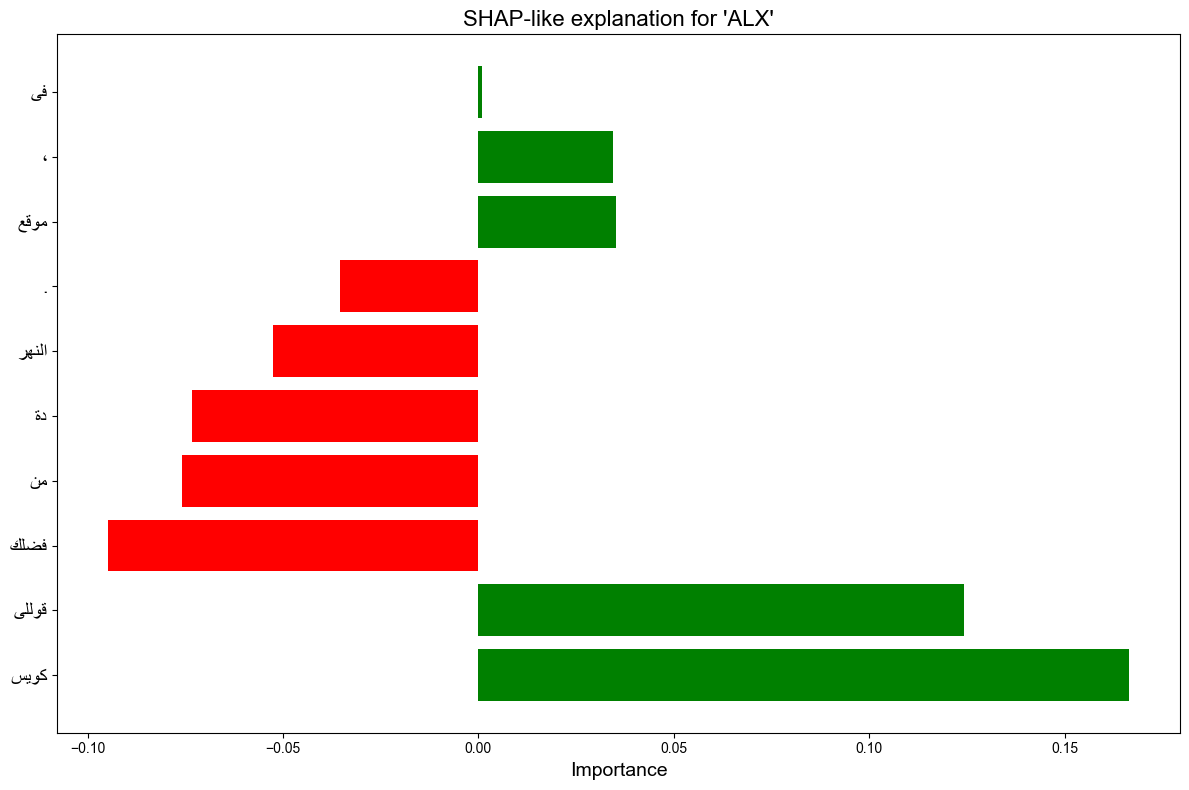


SHAP-like explanation for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Words contributing to prediction:
مرة: 1.2524
استخدمت: 1.2169
.: 0.2803
حتشيك: 0.1948
دا: 0.1654
؟: -0.0513
الغسيل: 0.0386
تانية: 0.0248
ما: -0.0218
خدمة: 0.0207


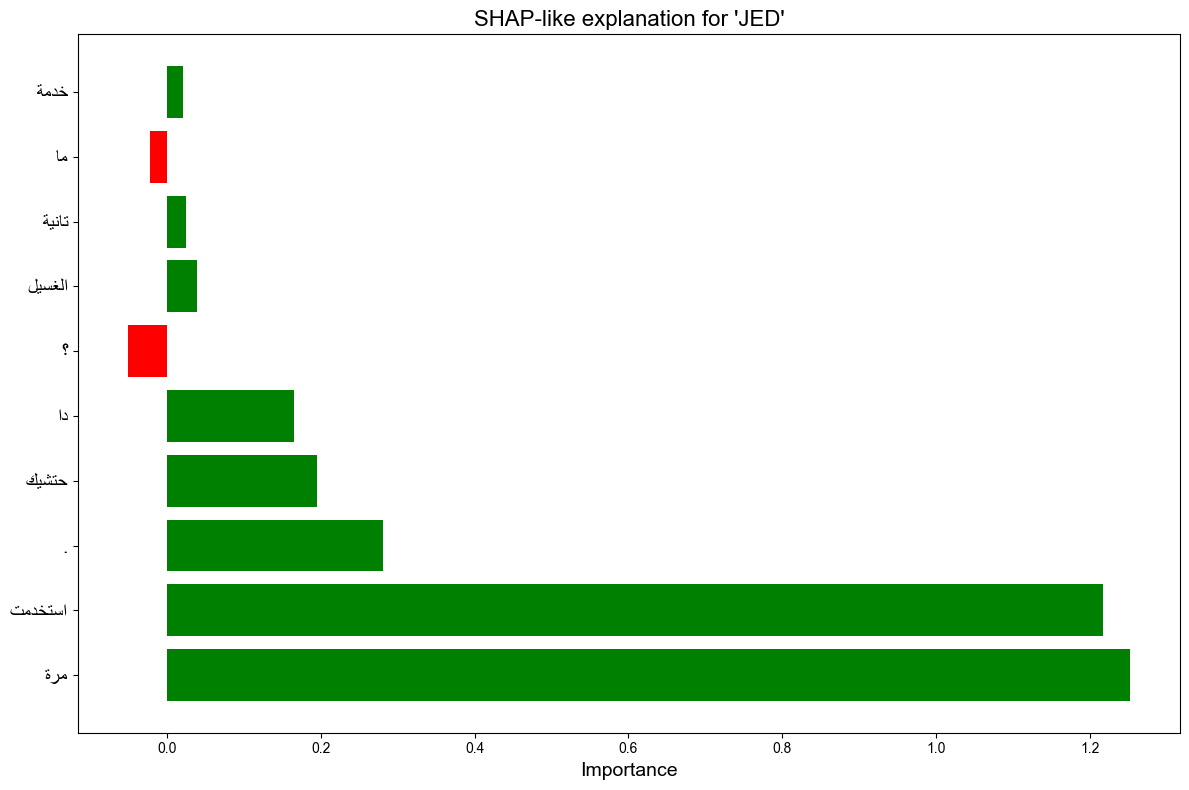


SHAP-like explanation for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Words contributing to prediction:
خل: 0.4179
الشناط: 0.2620
ثلاث: 0.2279
لو: -0.2184
لي: 0.2168
سمحت: 0.0397
.: -0.0237


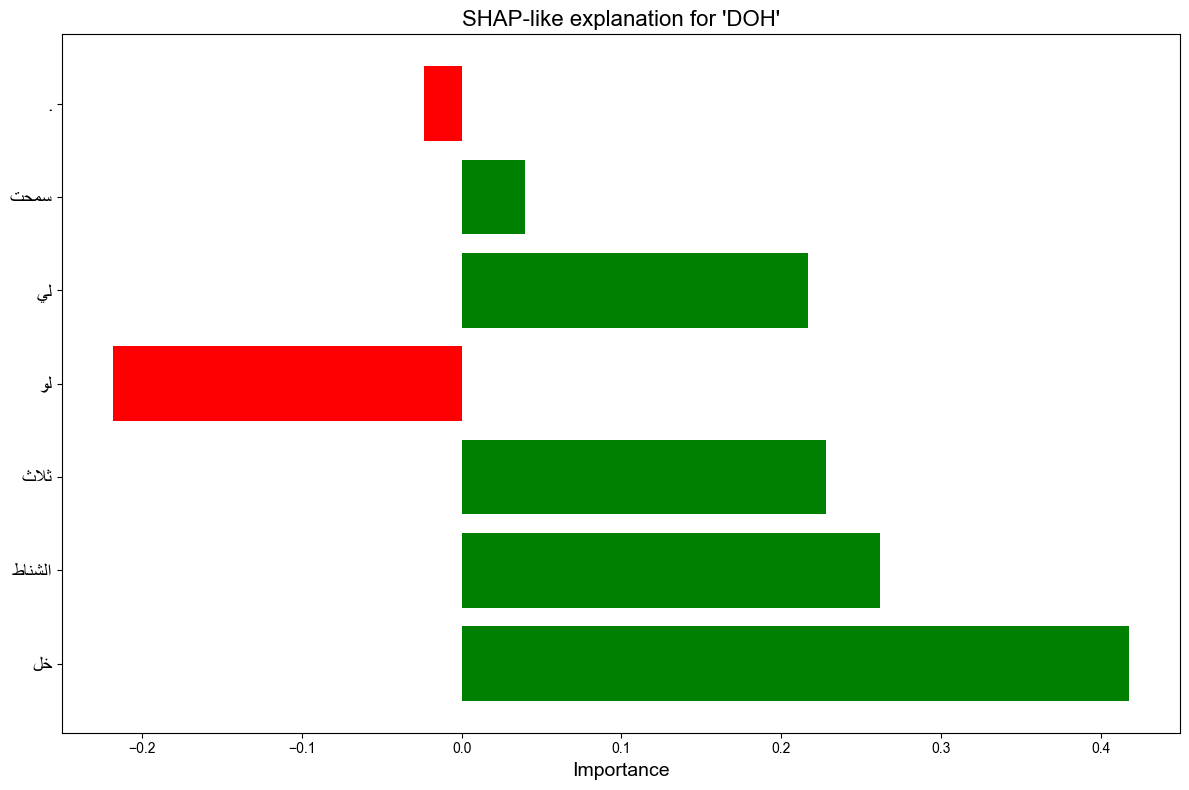


SHAP-like explanation for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS

Words contributing to prediction:
اطول: 2.0180
شي: 0.8136
عندي: 0.6411
شوي: 0.5113
اي: 0.4590
؟: 0.0550


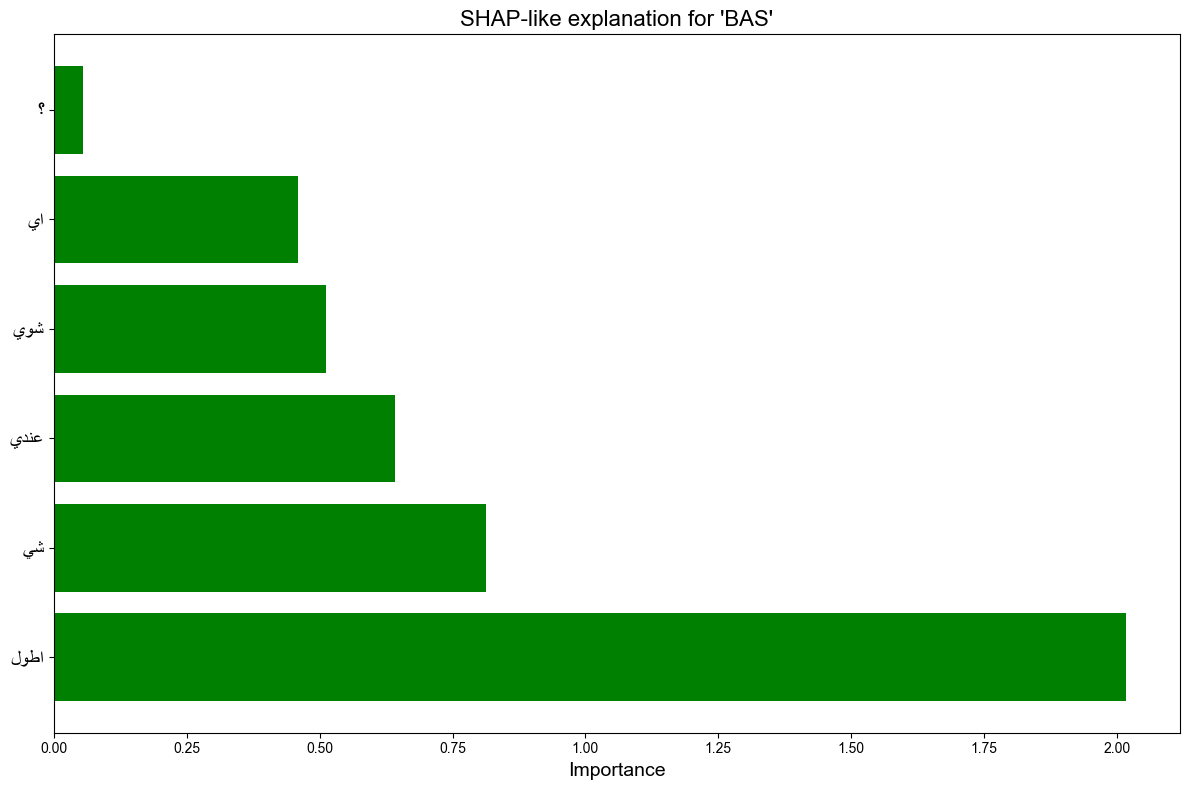

In [14]:
# Create the model wrapper
model_wrapper = BertModelWrapper(model, tokenizer)

# Generate SHAP-like explanations for each sample
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nSHAP-like explanation for Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Get the predicted class index
    pred_idx = dialect_to_id[pred_dialect]
    
    try:
        # Generate explanation
        importances = explain_with_shap(text, model_wrapper, tokenizer, pred_idx)
        
        # Sort by absolute importance
        importances.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the most important words
        print("\nWords contributing to prediction:")
        for word, importance in importances[:10]:
            print(f"{word}: {importance:.4f}")
        
        # Plot the explanation
        plt.figure(figsize=(12, 8))
        words = [x[0] for x in importances[:10]]
        values = [x[1] for x in importances[:10]]
        
        # Create horizontal bar chart
        colors = ['red' if v < 0 else 'green' for v in values]
        plt.barh(range(len(words)), values, color=colors)
        plt.yticks(range(len(words)), [display_arabic(w) for w in words], fontsize=14)
        plt.xlabel('Importance', fontsize=14)
        plt.title(f"SHAP-like explanation for '{pred_dialect}'", fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating explanation: {e}")


## 9. Attention Visualization

## 8. SHAP-like Explanations

SHAP (SHapley Additive exPlanations) provides another approach to explain model predictions by assigning importance values to each feature.

## 8. SHAP-like Explanations

SHAP (SHapley Additive exPlanations) provides another approach to explain model predictions by assigning importance values to each feature.

## 8. SHAP-like Explanations

SHAP (SHapley Additive exPlanations) provides another approach to explain model predictions by assigning importance values to each feature.

In [ ]:
# Create a model wrapper for SHAP that works with text data
class BertModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def __call__(self, texts):
        # Handle both string and list inputs
        if isinstance(texts, str):
            texts = [texts]
            
        # Tokenize the texts
        encoded_texts = []
        for text in texts:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded_texts.append(encoded)
        
        # Get model predictions
        outputs = []
        for encoded in encoded_texts:
            input_ids = encoded['input_ids'].to(self.device)
            attention_mask = encoded['attention_mask'].to(self.device)
            
            with torch.no_grad():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits
                outputs.append(logits.cpu().numpy()[0])
                
        return np.array(outputs)

In [ ]:
# Create a custom explainer function for SHAP
def explain_with_shap(text, model_wrapper, tokenizer, pred_idx):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Create a mapping from tokens to words
    word_tokens = []
    current_word = ""
    for token in tokens:
        if token.startswith('##'):
            current_word += token[2:]
        else:
            if current_word:
                word_tokens.append(current_word)
            current_word = token
    if current_word:
        word_tokens.append(current_word)
    
    # Create a baseline (empty text)
    baseline = ""
    
    # Calculate importance for each word
    importances = []
    for i, word in enumerate(word_tokens):
        # Create a masked version without this word
        masked_text = text.replace(word, "")
        
        # Get predictions for original and masked text
        original_pred = model_wrapper(text)[0][pred_idx]
        masked_pred = model_wrapper(masked_text)[0][pred_idx]
        
        # Calculate importance
        importance = original_pred - masked_pred
        importances.append((word, importance))
    
    return importances


SHAP-like explanation for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Words contributing to prediction:
ميا: 2.7730
كيدا: 0.2803
سبعة: 0.2558
انا: -0.1462
عشرين: -0.0624
بيت: -0.0404
في: 0.0332
و: 0.0283
و: 0.0283
.: -0.0083


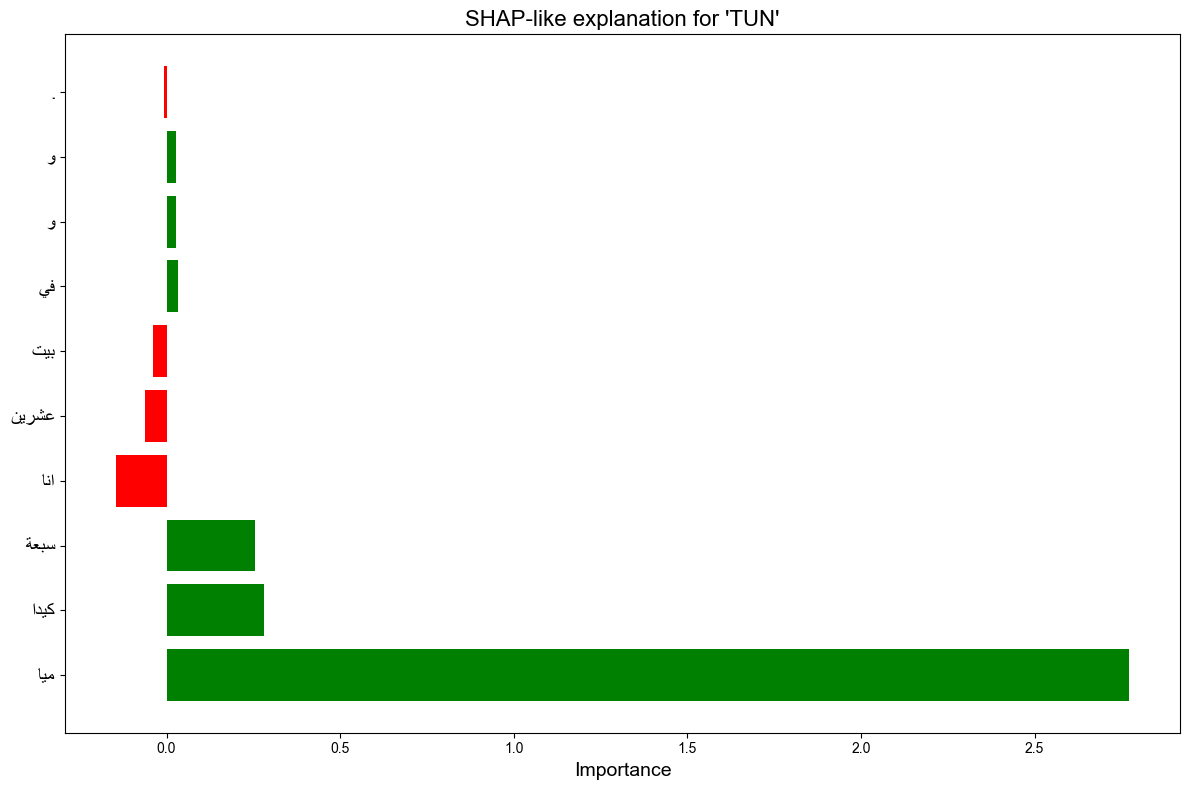


SHAP-like explanation for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Words contributing to prediction:
كويس: 0.1665
قوللى: 0.1243
فضلك: -0.0947
من: -0.0759
دة: -0.0734
النهر: -0.0525
.: -0.0353
موقع: 0.0353
،: 0.0344
فى: 0.0009


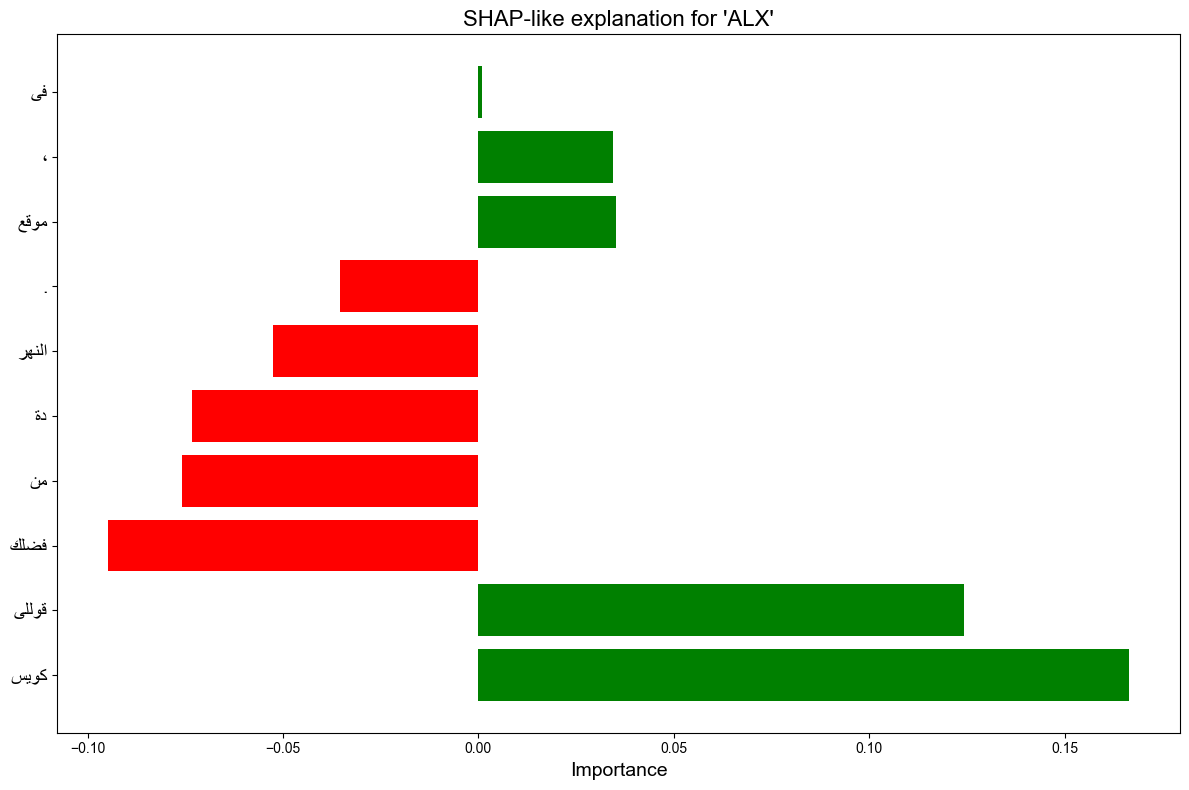


SHAP-like explanation for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Words contributing to prediction:
مرة: 1.2524
استخدمت: 1.2169
.: 0.2803
حتشيك: 0.1948
دا: 0.1654
؟: -0.0513
الغسيل: 0.0386
تانية: 0.0248
ما: -0.0218
خدمة: 0.0207


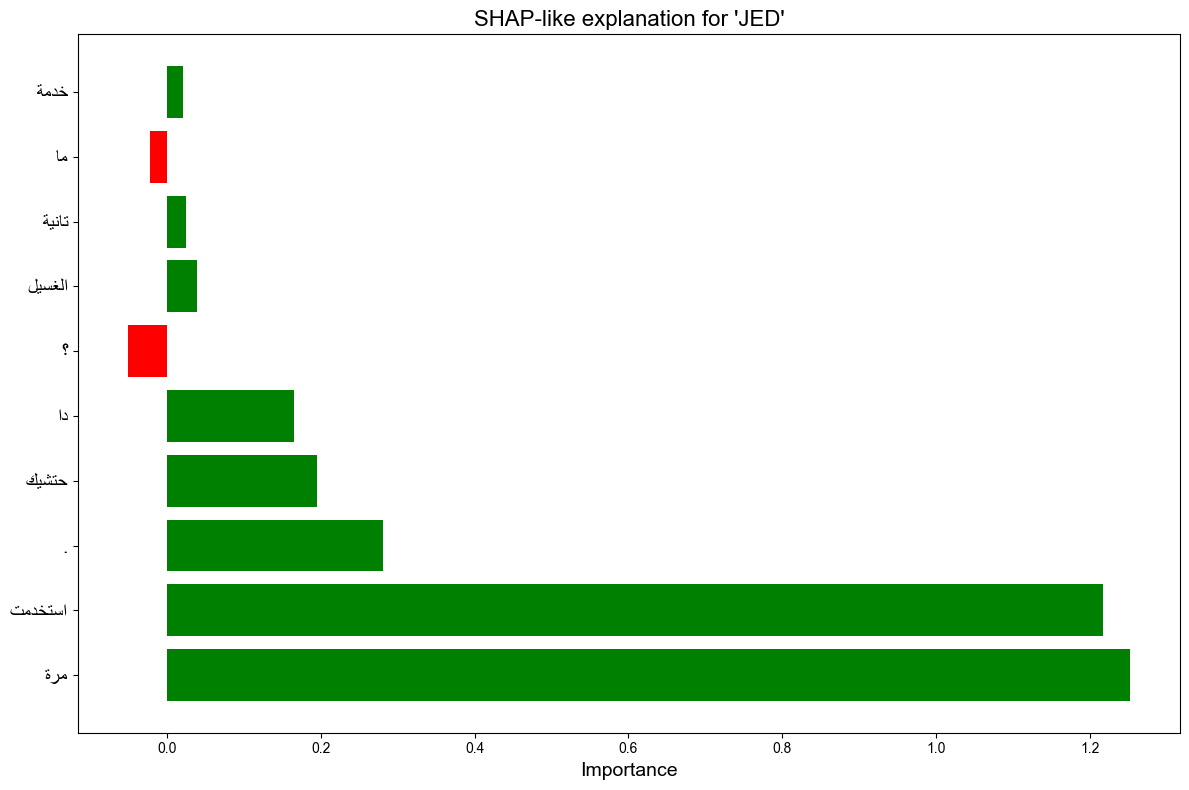


SHAP-like explanation for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Words contributing to prediction:
خل: 0.4179
الشناط: 0.2620
ثلاث: 0.2279
لو: -0.2184
لي: 0.2168
سمحت: 0.0397
.: -0.0237


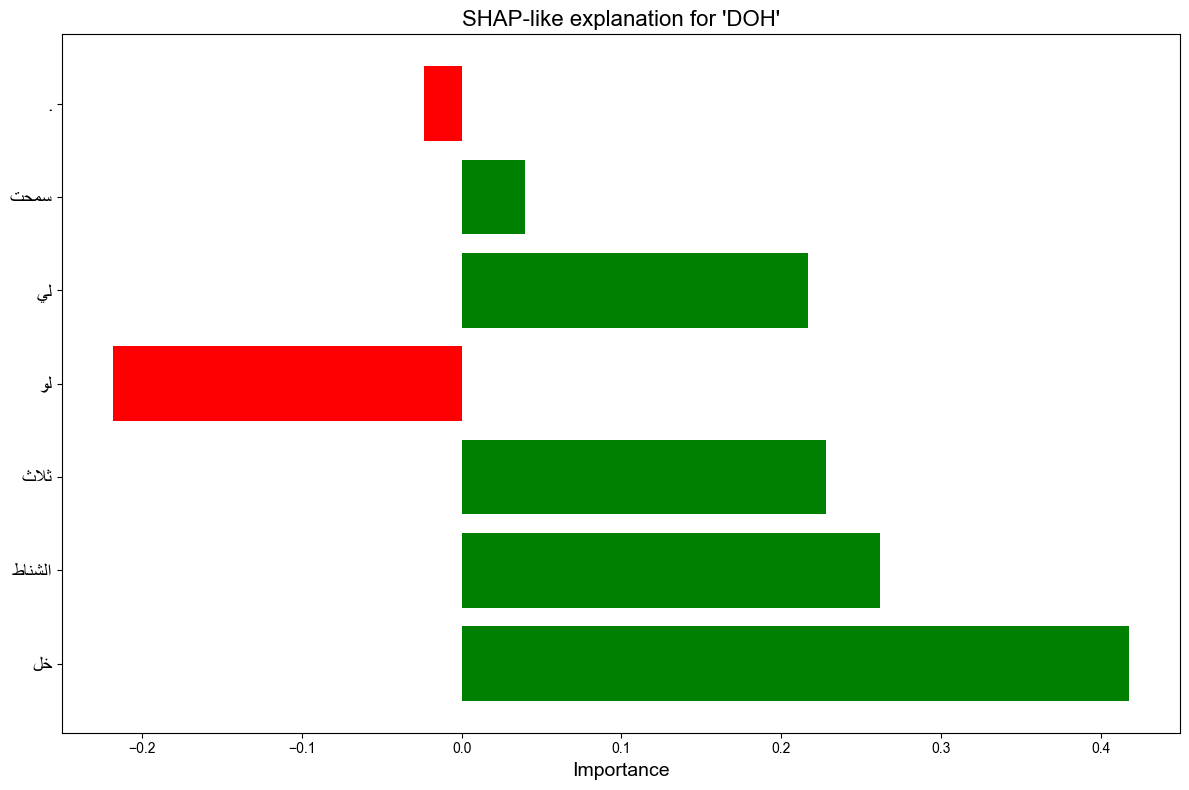


SHAP-like explanation for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS

Words contributing to prediction:
اطول: 2.0180
شي: 0.8136
عندي: 0.6411
شوي: 0.5113
اي: 0.4590
؟: 0.0550


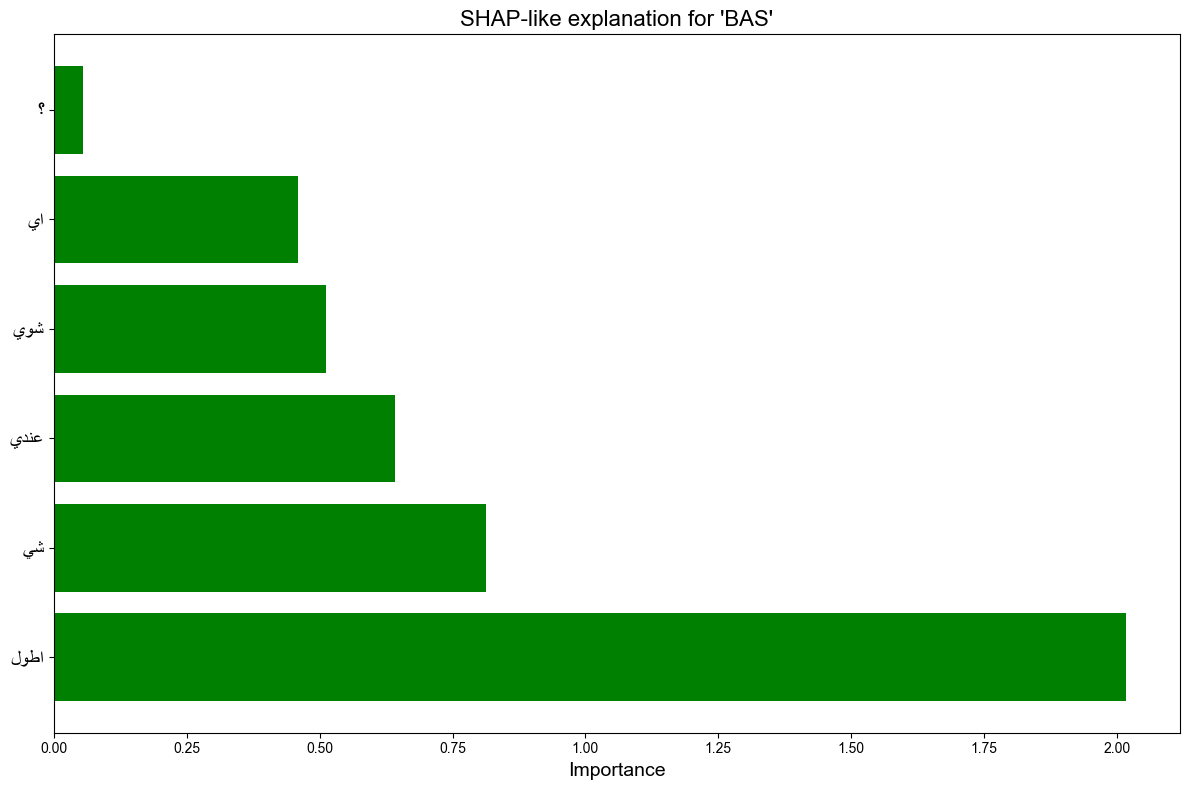

In [ ]:
# Create the model wrapper
model_wrapper = BertModelWrapper(model, tokenizer)

# Generate SHAP-like explanations for each sample
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nSHAP-like explanation for Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Get the predicted class index
    pred_idx = dialect_to_id[pred_dialect]
    
    try:
        # Generate explanation
        importances = explain_with_shap(text, model_wrapper, tokenizer, pred_idx)
        
        # Sort by absolute importance
        importances.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the most important words
        print("\nWords contributing to prediction:")
        for word, importance in importances[:10]:
            print(f"{word}: {importance:.4f}")
        
        # Plot the explanation
        plt.figure(figsize=(12, 8))
        words = [x[0] for x in importances[:10]]
        values = [x[1] for x in importances[:10]]
        
        # Create horizontal bar chart
        colors = ['red' if v < 0 else 'green' for v in values]
        plt.barh(range(len(words)), values, color=colors)
        plt.yticks(range(len(words)), [display_arabic(w) for w in words], fontsize=14)
        plt.xlabel('Importance', fontsize=14)
        plt.title(f"SHAP-like explanation for '{pred_dialect}'", fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating explanation: {e}")


In [ ]:
# Create a model wrapper for SHAP that works with text data
class BertModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def __call__(self, texts):
        # Handle both string and list inputs
        if isinstance(texts, str):
            texts = [texts]
            
        # Tokenize the texts
        encoded_texts = []
        for text in texts:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded_texts.append(encoded)
        
        # Get model predictions
        outputs = []
        for encoded in encoded_texts:
            input_ids = encoded['input_ids'].to(self.device)
            attention_mask = encoded['attention_mask'].to(self.device)
            
            with torch.no_grad():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits
                outputs.append(logits.cpu().numpy()[0])
                
        return np.array(outputs)

In [ ]:
# Create a custom explainer function for SHAP
def explain_with_shap(text, model_wrapper, tokenizer, pred_idx):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Create a mapping from tokens to words
    word_tokens = []
    current_word = ""
    for token in tokens:
        if token.startswith('##'):
            current_word += token[2:]
        else:
            if current_word:
                word_tokens.append(current_word)
            current_word = token
    if current_word:
        word_tokens.append(current_word)
    
    # Create a baseline (empty text)
    baseline = ""
    
    # Calculate importance for each word
    importances = []
    for i, word in enumerate(word_tokens):
        # Create a masked version without this word
        masked_text = text.replace(word, "")
        
        # Get predictions for original and masked text
        original_pred = model_wrapper(text)[0][pred_idx]
        masked_pred = model_wrapper(masked_text)[0][pred_idx]
        
        # Calculate importance
        importance = original_pred - masked_pred
        importances.append((word, importance))
    
    return importances


SHAP-like explanation for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Words contributing to prediction:
ميا: 2.7730
كيدا: 0.2803
سبعة: 0.2558
انا: -0.1462
عشرين: -0.0624
بيت: -0.0404
في: 0.0332
و: 0.0283
و: 0.0283
.: -0.0083


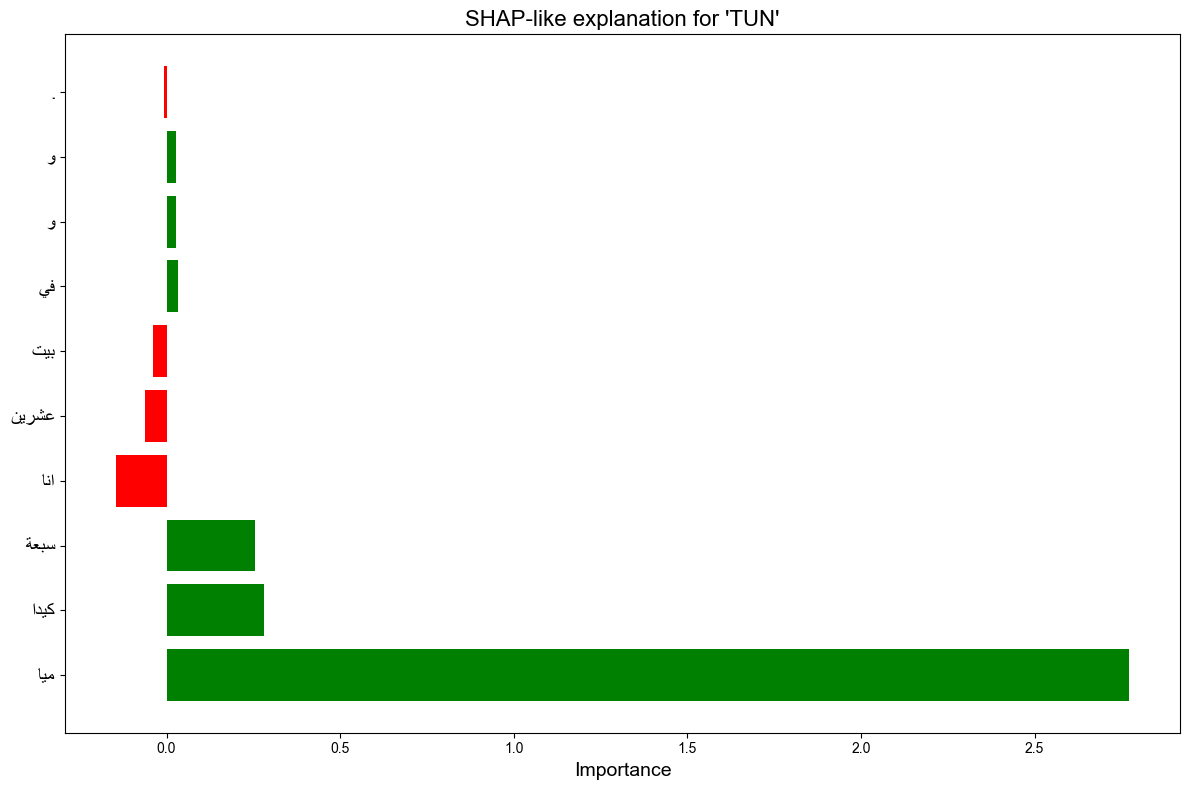


SHAP-like explanation for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Words contributing to prediction:
كويس: 0.1665
قوللى: 0.1243
فضلك: -0.0947
من: -0.0759
دة: -0.0734
النهر: -0.0525
.: -0.0353
موقع: 0.0353
،: 0.0344
فى: 0.0009


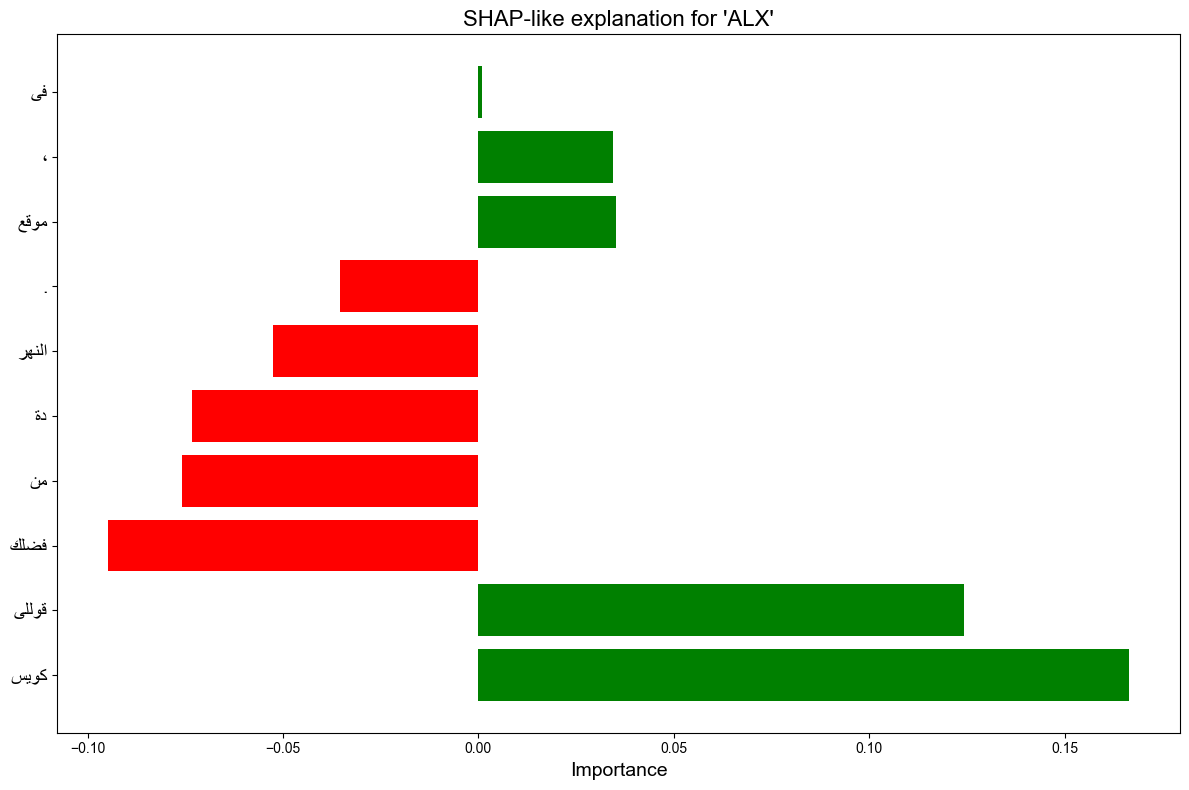


SHAP-like explanation for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Words contributing to prediction:
مرة: 1.2524
استخدمت: 1.2169
.: 0.2803
حتشيك: 0.1948
دا: 0.1654
؟: -0.0513
الغسيل: 0.0386
تانية: 0.0248
ما: -0.0218
خدمة: 0.0207


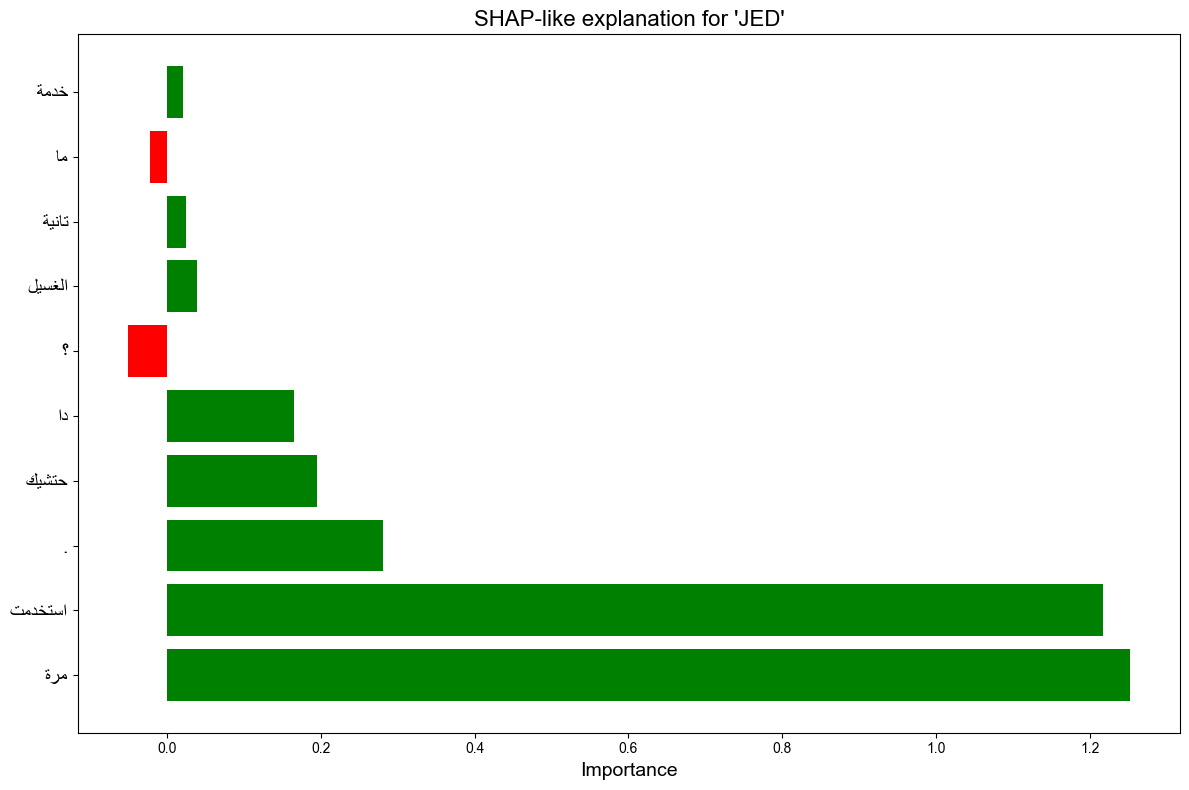


SHAP-like explanation for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Words contributing to prediction:
خل: 0.4179
الشناط: 0.2620
ثلاث: 0.2279
لو: -0.2184
لي: 0.2168
سمحت: 0.0397
.: -0.0237


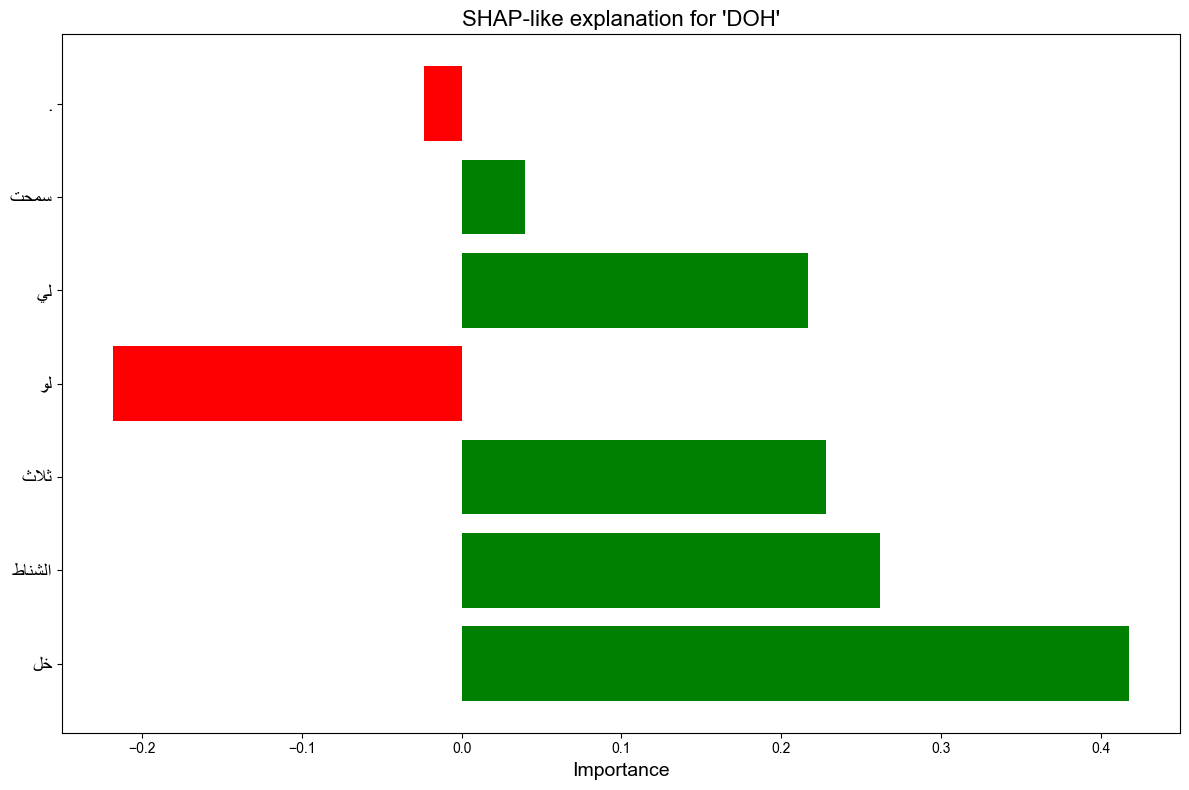


SHAP-like explanation for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS

Words contributing to prediction:
اطول: 2.0180
شي: 0.8136
عندي: 0.6411
شوي: 0.5113
اي: 0.4590
؟: 0.0550


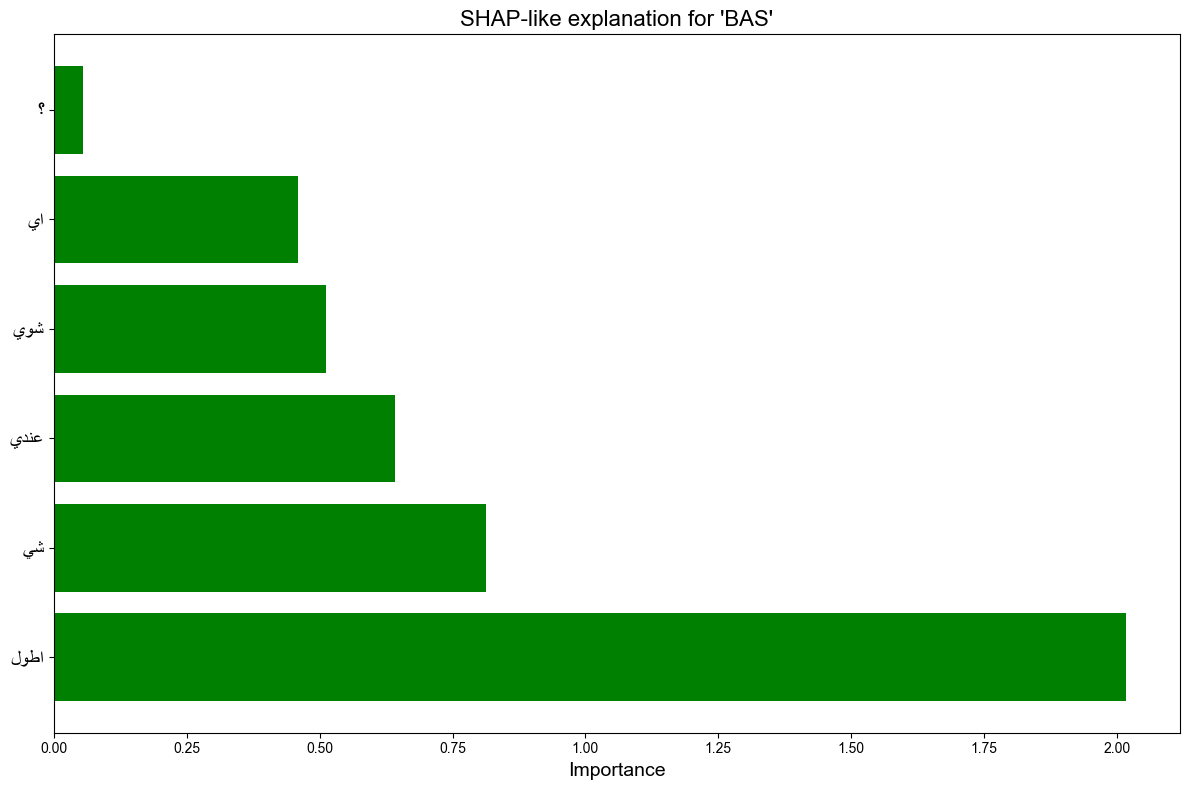

In [ ]:
# Create the model wrapper
model_wrapper = BertModelWrapper(model, tokenizer)

# Generate SHAP-like explanations for each sample
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nSHAP-like explanation for Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Get the predicted class index
    pred_idx = dialect_to_id[pred_dialect]
    
    try:
        # Generate explanation
        importances = explain_with_shap(text, model_wrapper, tokenizer, pred_idx)
        
        # Sort by absolute importance
        importances.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the most important words
        print("\nWords contributing to prediction:")
        for word, importance in importances[:10]:
            print(f"{word}: {importance:.4f}")
        
        # Plot the explanation
        plt.figure(figsize=(12, 8))
        words = [x[0] for x in importances[:10]]
        values = [x[1] for x in importances[:10]]
        
        # Create horizontal bar chart
        colors = ['red' if v < 0 else 'green' for v in values]
        plt.barh(range(len(words)), values, color=colors)
        plt.yticks(range(len(words)), [display_arabic(w) for w in words], fontsize=14)
        plt.xlabel('Importance', fontsize=14)
        plt.title(f"SHAP-like explanation for '{pred_dialect}'", fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating explanation: {e}")


In [ ]:
# Create a model wrapper for SHAP that works with text data
class BertModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def __call__(self, texts):
        # Handle both string and list inputs
        if isinstance(texts, str):
            texts = [texts]
            
        # Tokenize the texts
        encoded_texts = []
        for text in texts:
            encoded = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            encoded_texts.append(encoded)
        
        # Get model predictions
        outputs = []
        for encoded in encoded_texts:
            input_ids = encoded['input_ids'].to(self.device)
            attention_mask = encoded['attention_mask'].to(self.device)
            
            with torch.no_grad():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = output.logits
                outputs.append(logits.cpu().numpy()[0])
                
        return np.array(outputs)

In [ ]:
# Create a custom explainer function for SHAP
def explain_with_shap(text, model_wrapper, tokenizer, pred_idx):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    
    # Create a mapping from tokens to words
    word_tokens = []
    current_word = ""
    for token in tokens:
        if token.startswith('##'):
            current_word += token[2:]
        else:
            if current_word:
                word_tokens.append(current_word)
            current_word = token
    if current_word:
        word_tokens.append(current_word)
    
    # Create a baseline (empty text)
    baseline = ""
    
    # Calculate importance for each word
    importances = []
    for i, word in enumerate(word_tokens):
        # Create a masked version without this word
        masked_text = text.replace(word, "")
        
        # Get predictions for original and masked text
        original_pred = model_wrapper(text)[0][pred_idx]
        masked_pred = model_wrapper(masked_text)[0][pred_idx]
        
        # Calculate importance
        importance = original_pred - masked_pred
        importances.append((word, importance))
    
    return importances


SHAP-like explanation for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN

Words contributing to prediction:
ميا: 2.7730
كيدا: 0.2803
سبعة: 0.2558
انا: -0.1462
عشرين: -0.0624
بيت: -0.0404
في: 0.0332
و: 0.0283
و: 0.0283
.: -0.0083


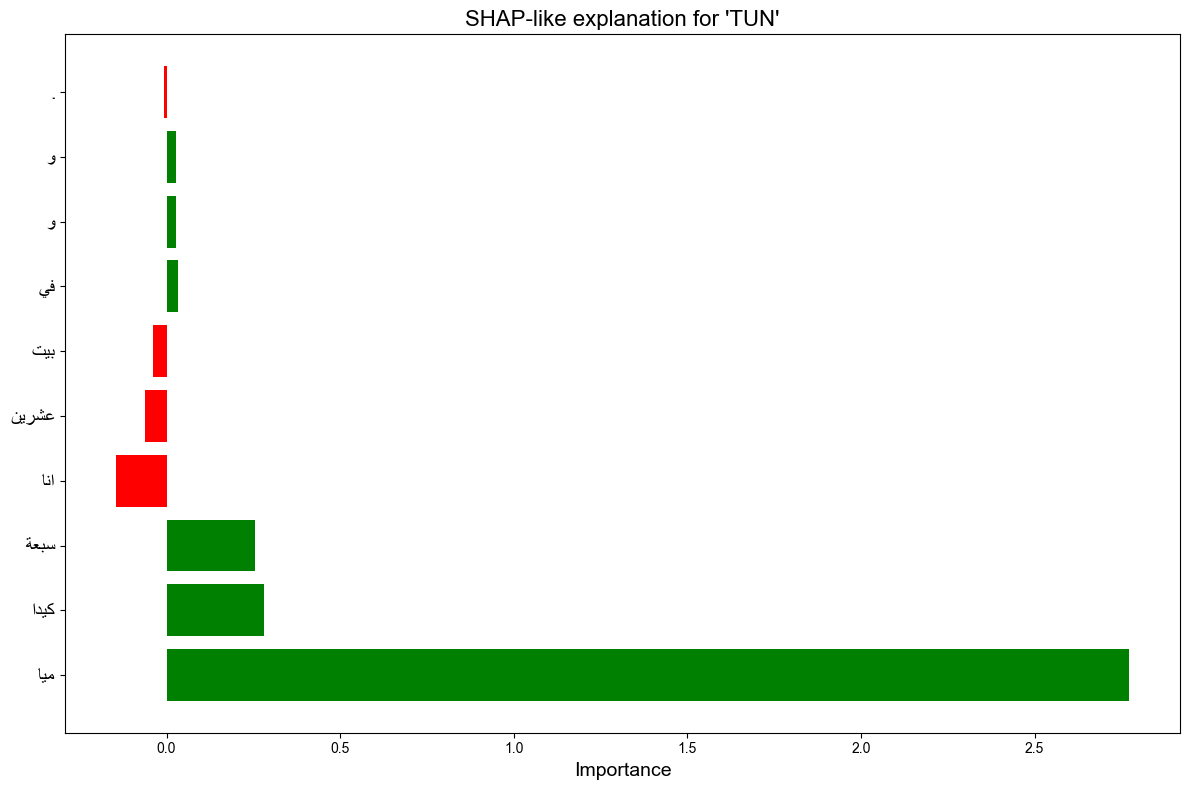


SHAP-like explanation for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX

Words contributing to prediction:
كويس: 0.1665
قوللى: 0.1243
فضلك: -0.0947
من: -0.0759
دة: -0.0734
النهر: -0.0525
.: -0.0353
موقع: 0.0353
،: 0.0344
فى: 0.0009


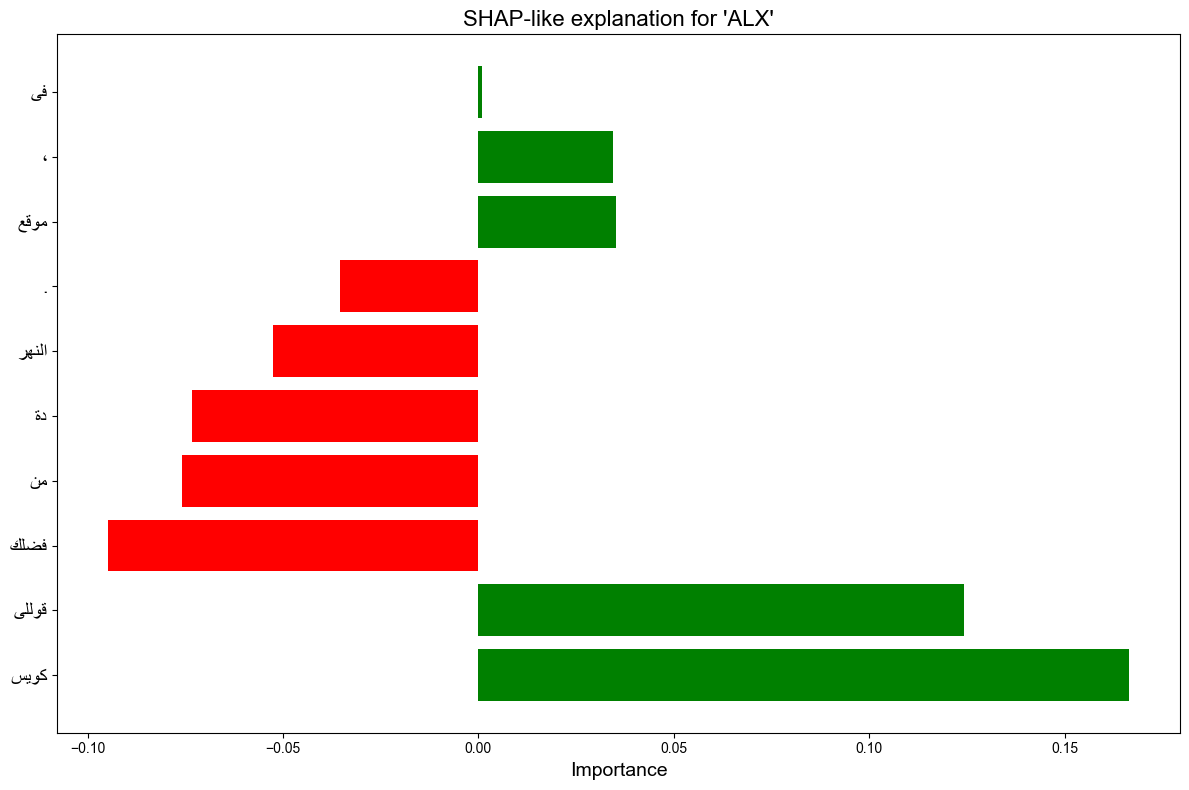


SHAP-like explanation for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED

Words contributing to prediction:
مرة: 1.2524
استخدمت: 1.2169
.: 0.2803
حتشيك: 0.1948
دا: 0.1654
؟: -0.0513
الغسيل: 0.0386
تانية: 0.0248
ما: -0.0218
خدمة: 0.0207


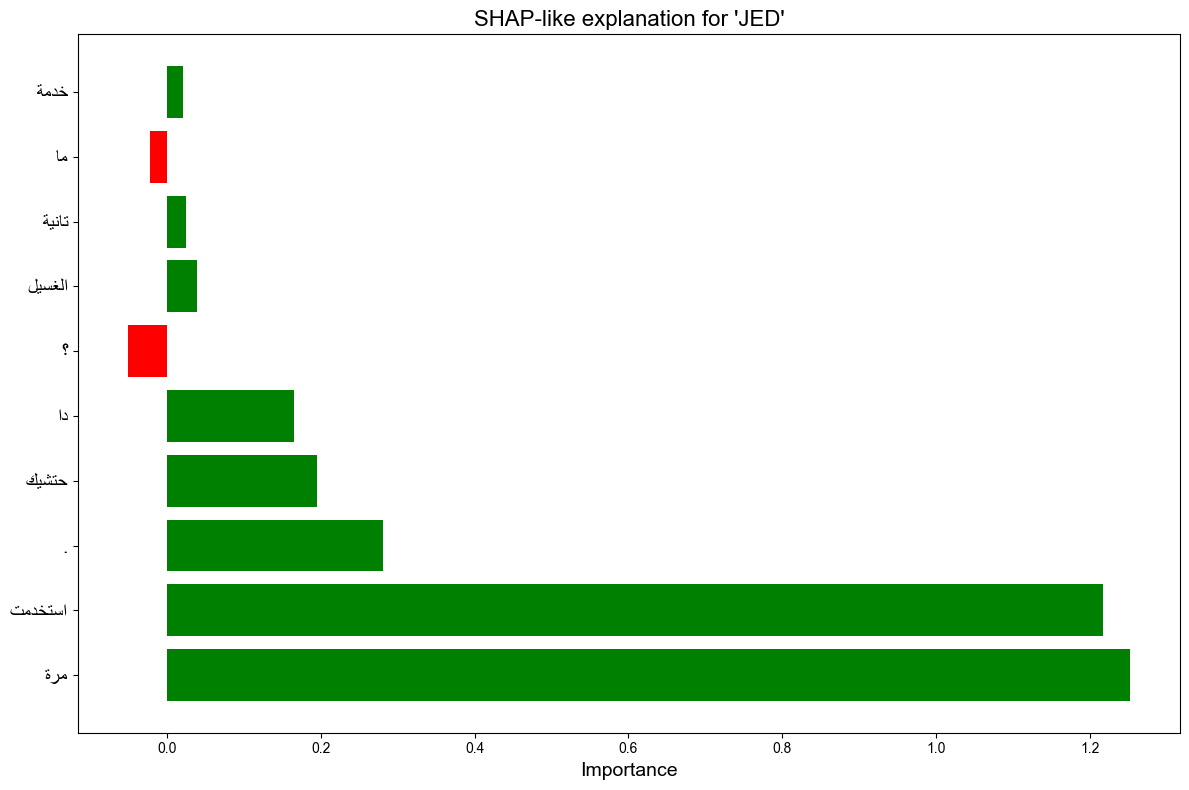


SHAP-like explanation for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH

Words contributing to prediction:
خل: 0.4179
الشناط: 0.2620
ثلاث: 0.2279
لو: -0.2184
لي: 0.2168
سمحت: 0.0397
.: -0.0237


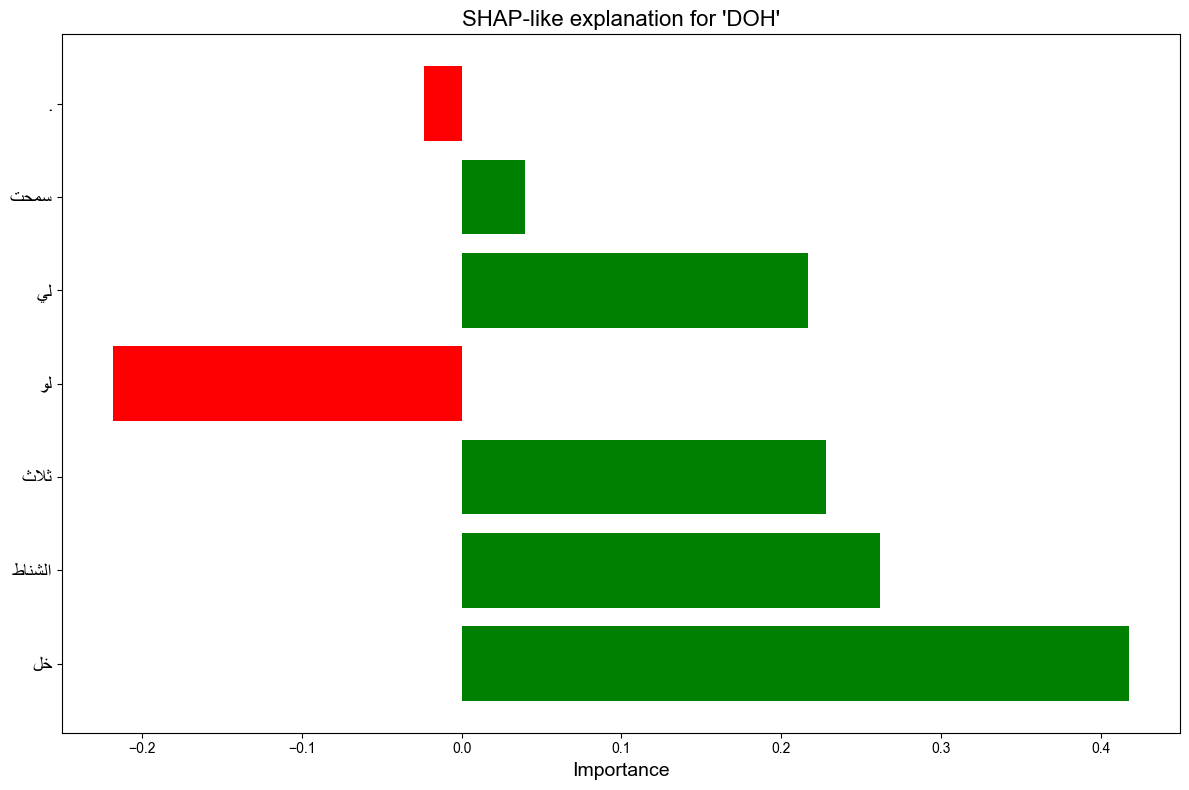


SHAP-like explanation for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS

Words contributing to prediction:
اطول: 2.0180
شي: 0.8136
عندي: 0.6411
شوي: 0.5113
اي: 0.4590
؟: 0.0550


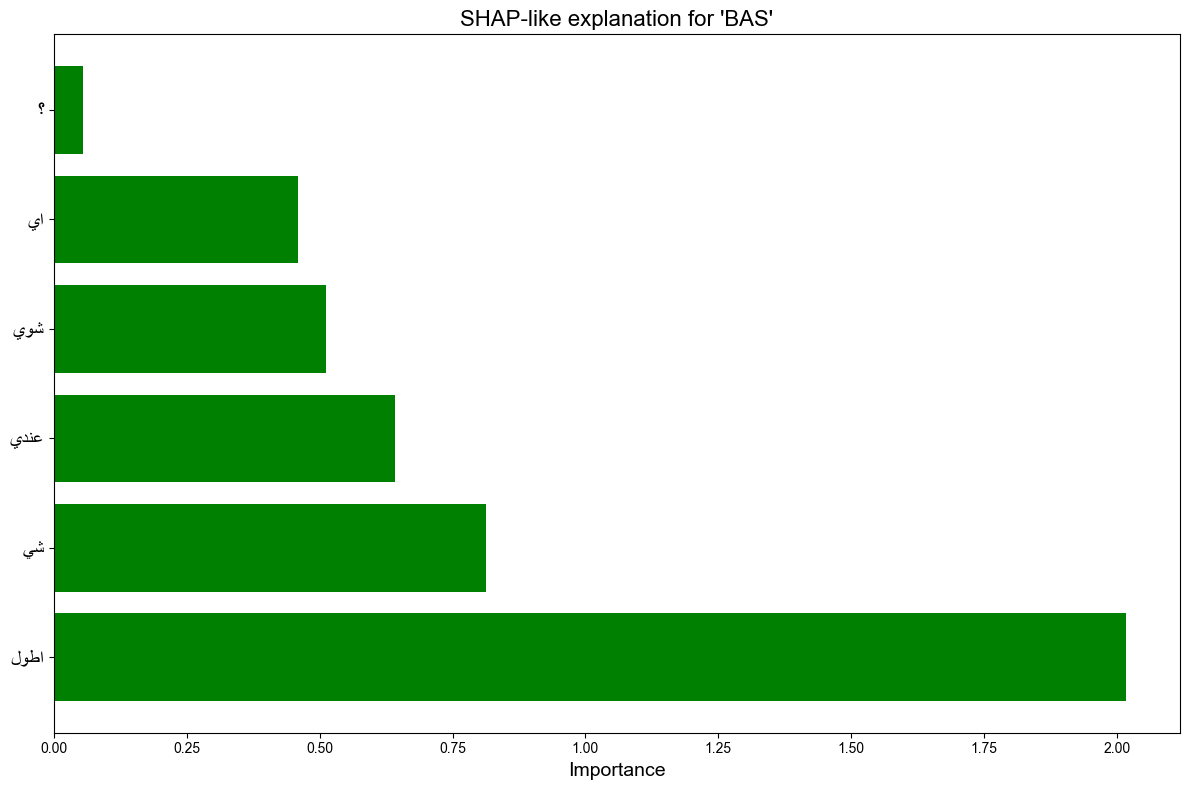

In [ ]:
# Create the model wrapper
model_wrapper = BertModelWrapper(model, tokenizer)

# Generate SHAP-like explanations for each sample
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nSHAP-like explanation for Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Get the predicted class index
    pred_idx = dialect_to_id[pred_dialect]
    
    try:
        # Generate explanation
        importances = explain_with_shap(text, model_wrapper, tokenizer, pred_idx)
        
        # Sort by absolute importance
        importances.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the most important words
        print("\nWords contributing to prediction:")
        for word, importance in importances[:10]:
            print(f"{word}: {importance:.4f}")
        
        # Plot the explanation
        plt.figure(figsize=(12, 8))
        words = [x[0] for x in importances[:10]]
        values = [x[1] for x in importances[:10]]
        
        # Create horizontal bar chart
        colors = ['red' if v < 0 else 'green' for v in values]
        plt.barh(range(len(words)), values, color=colors)
        plt.yticks(range(len(words)), [display_arabic(w) for w in words], fontsize=14)
        plt.xlabel('Importance', fontsize=14)
        plt.title(f"SHAP-like explanation for '{pred_dialect}'", fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating explanation: {e}")


In [9]:
# Function to get attention weights from the model
def get_attention_weights(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get attention weights
    with torch.no_grad():
        outputs = model.bert(**inputs, output_attentions=True)

    # Return attention weights
    return outputs.attentions

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


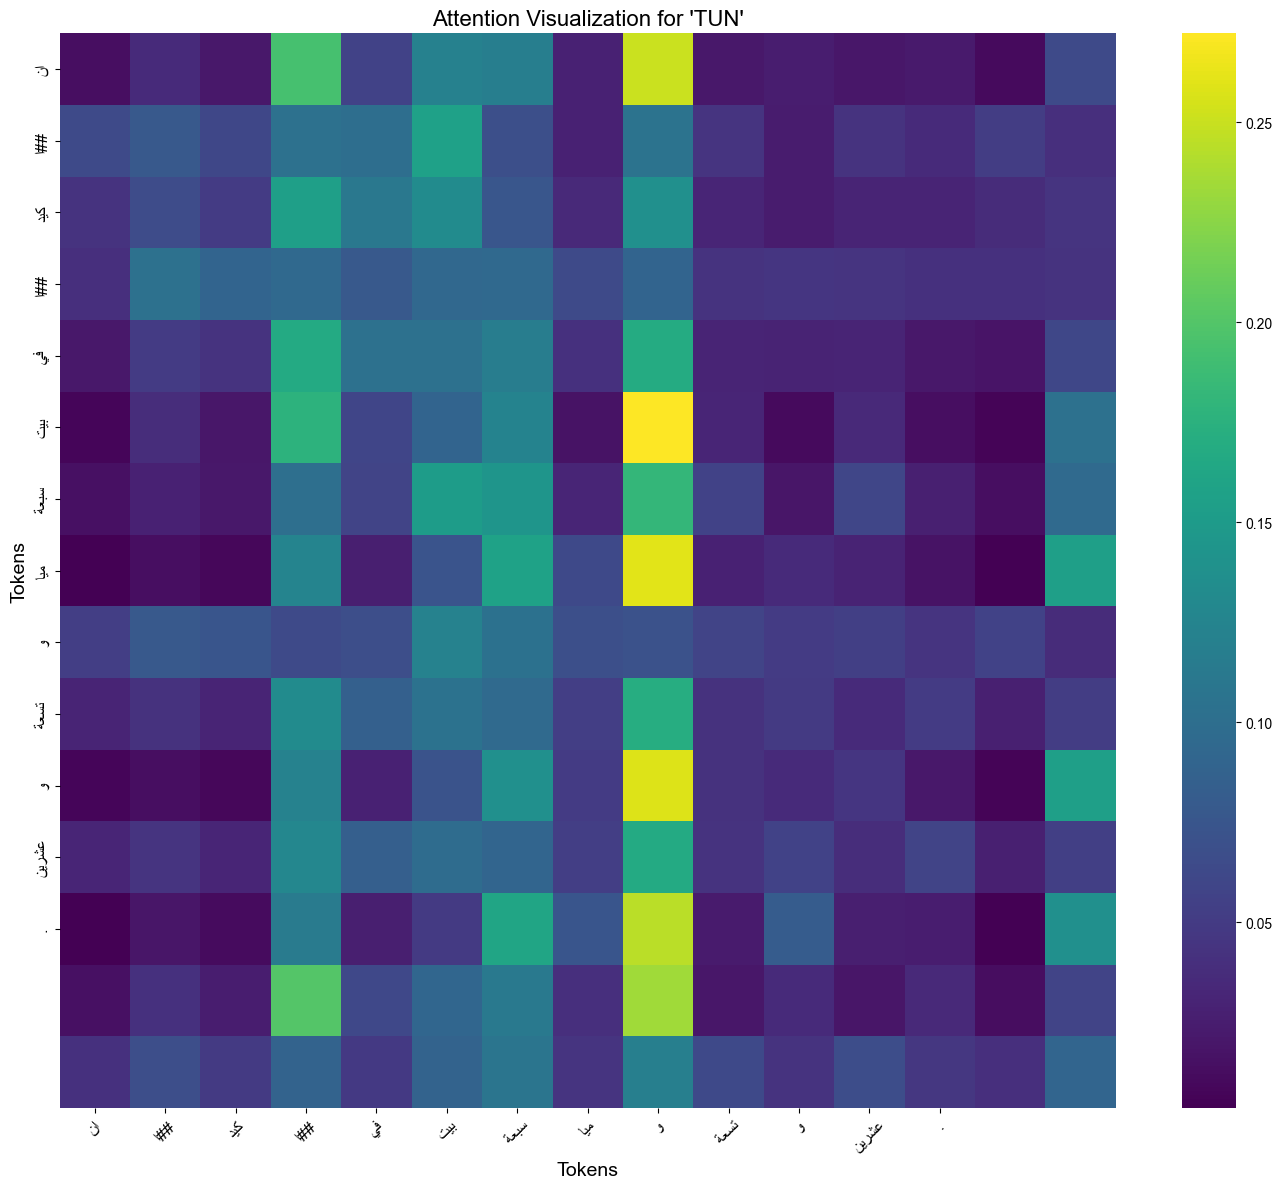

In [10]:
# Visualize attention for a sample text
sample_idx = 0  # Choose the first sample
sample_text = sample_texts[sample_idx]
sample_dialect = sample_true_dialects[sample_idx]
sample_pred_dialect = sample_pred_dialects[sample_idx]

# Get attention weights
attention_weights = get_attention_weights(sample_text)

# Get tokens
tokens = tokenizer.tokenize(sample_text)
tokens = [tokenizer.convert_ids_to_tokens(id) for id in tokenizer.encode(sample_text)][1:-1]  # Remove special tokens

# Visualize attention from the last layer, last head
last_layer_attn = attention_weights[-1][0].cpu().numpy()  # [layer][-1=last_layer][0=first_example][head]
last_head_attn = last_layer_attn[-1]  # Last attention head

# Plot attention heatmap with Arabic support
plt.figure(figsize=(14, 12))
sns.heatmap(last_head_attn, xticklabels=[display_arabic(t) for t in tokens], 
            yticklabels=[display_arabic(t) for t in tokens], cmap='viridis', annot=False)
plt.title(f"Attention Visualization for '{sample_pred_dialect}'", fontsize=16)
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Tokens", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


Attention visualization for Example 1:
Text: انا كيدا في بيت سبعة ميا و تسعة و عشرين.
True dialect: TUN
Predicted dialect: TUN


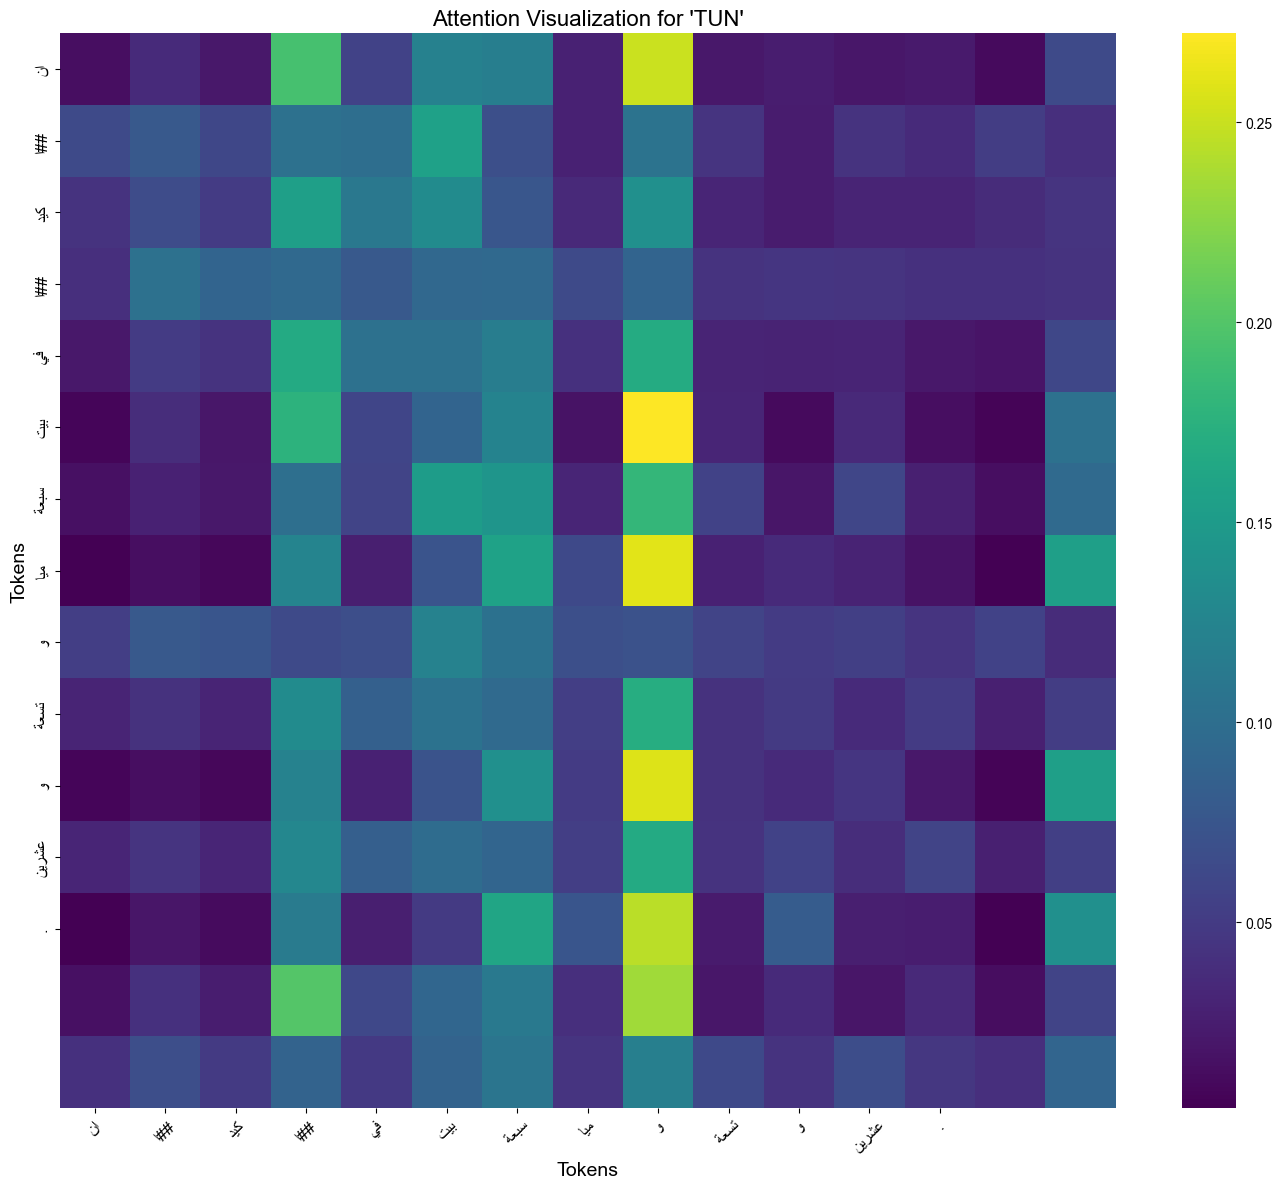


Attention visualization for Example 2:
Text: قوللى موقع كويس فى النهر دة، من فضلك.
True dialect: ALX
Predicted dialect: ALX


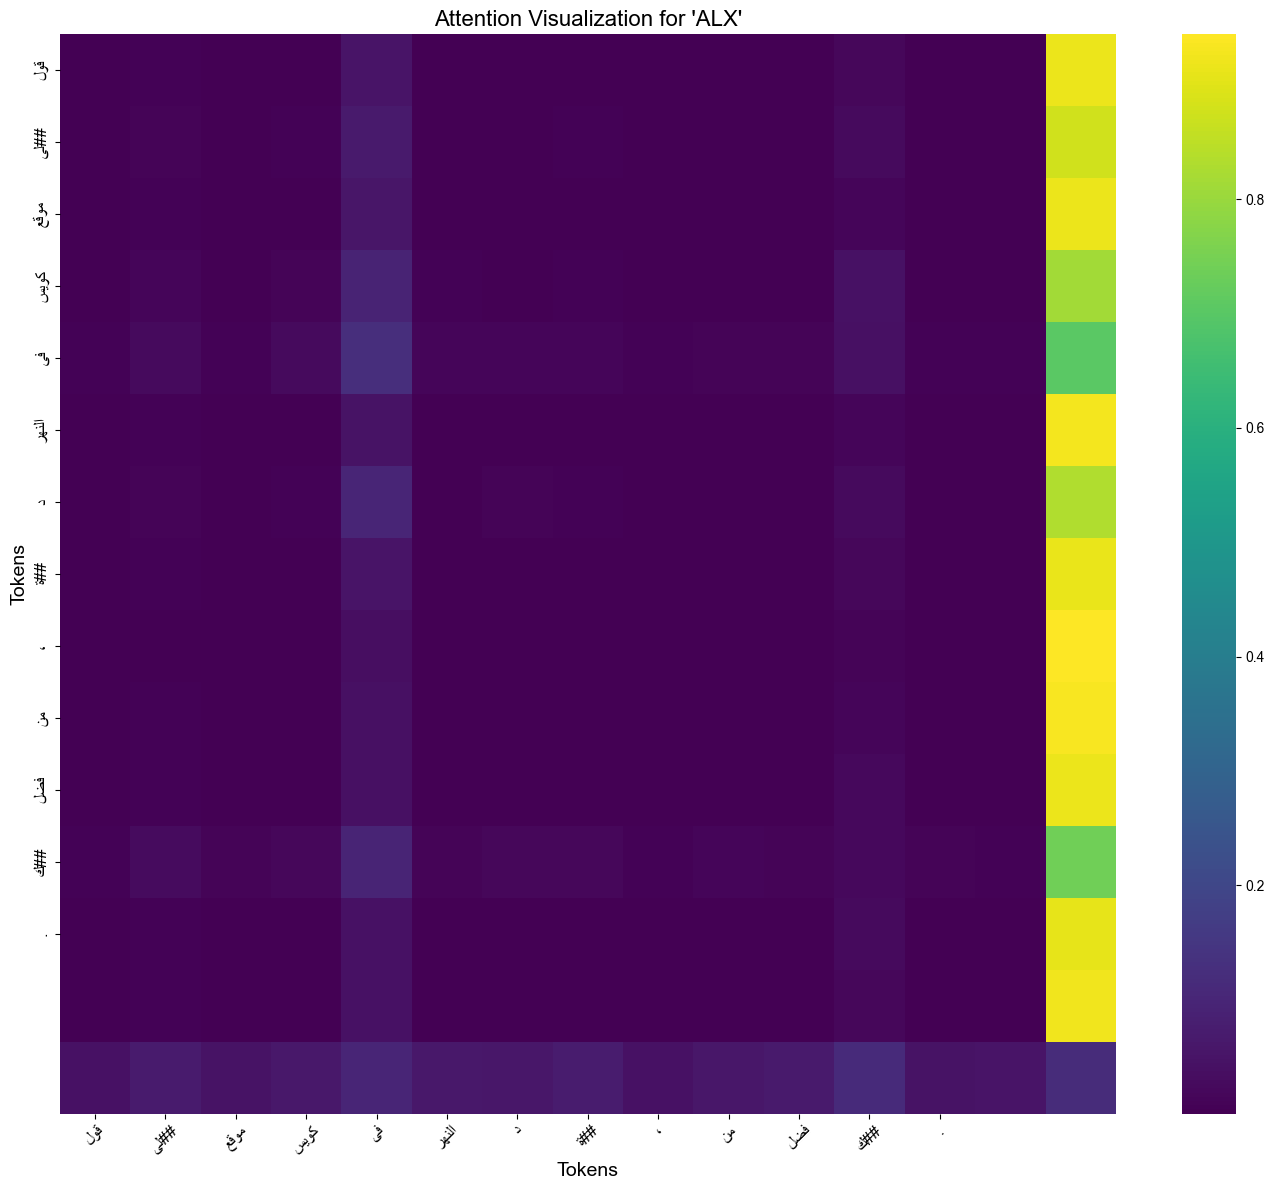


Attention visualization for Example 3:
Text: انا ما استخدمت خدمة الغسيل عندك. حتشيك دا مرة تانية؟
True dialect: JED
Predicted dialect: JED


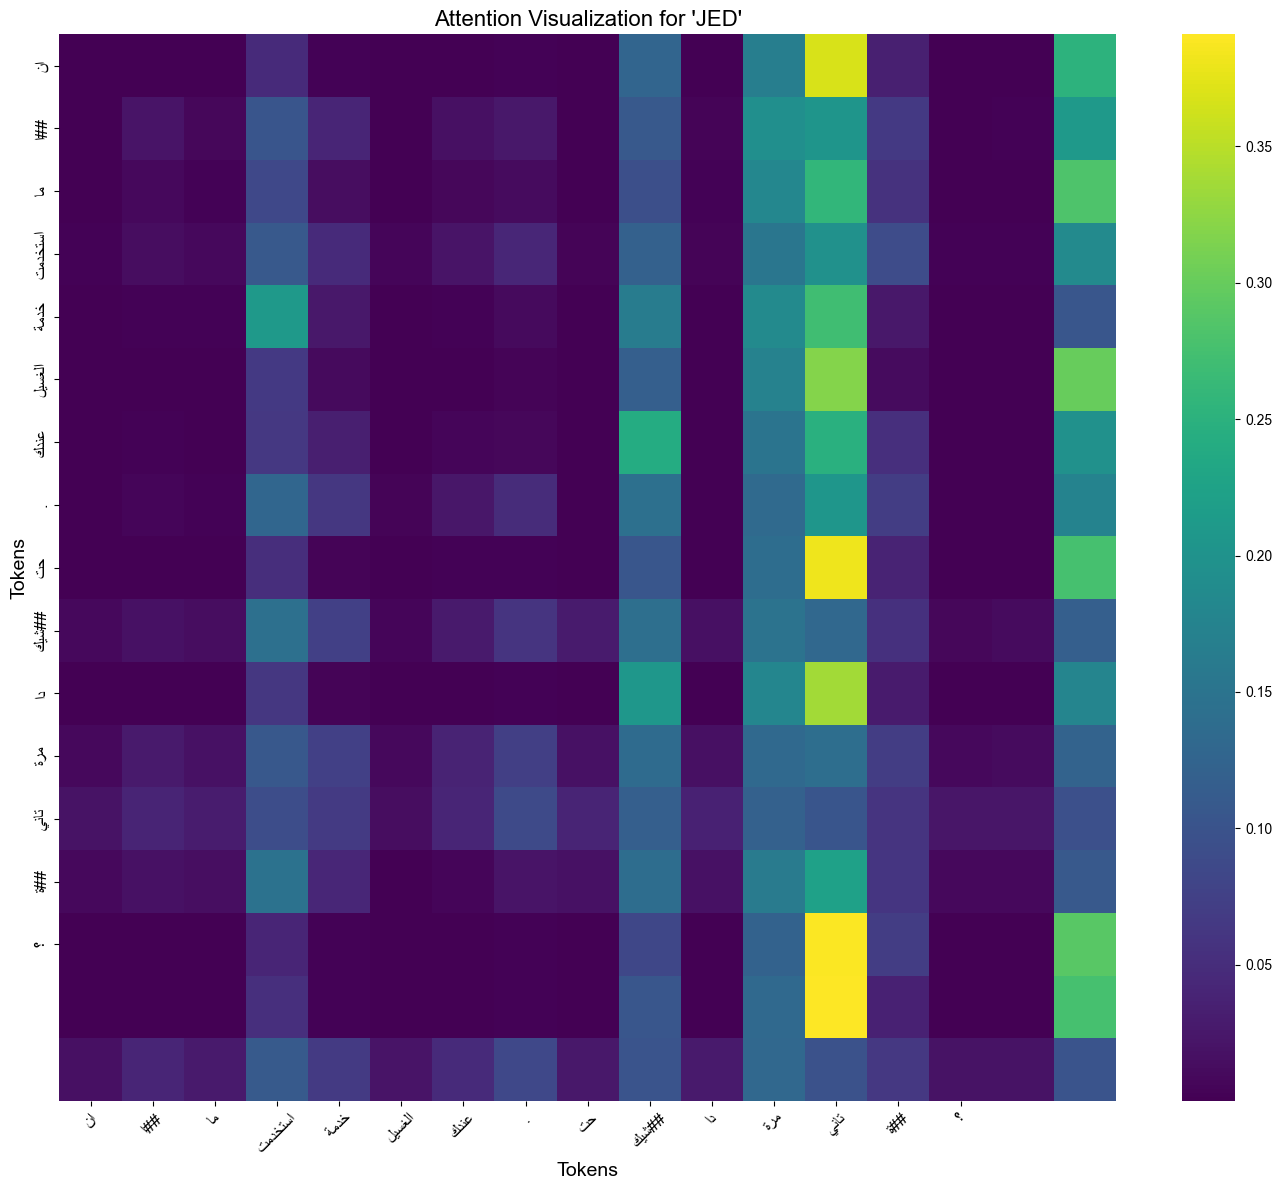


Attention visualization for Example 4:
Text: لو سمحت خل الشناط لي ثلاث.
True dialect: DOH
Predicted dialect: DOH


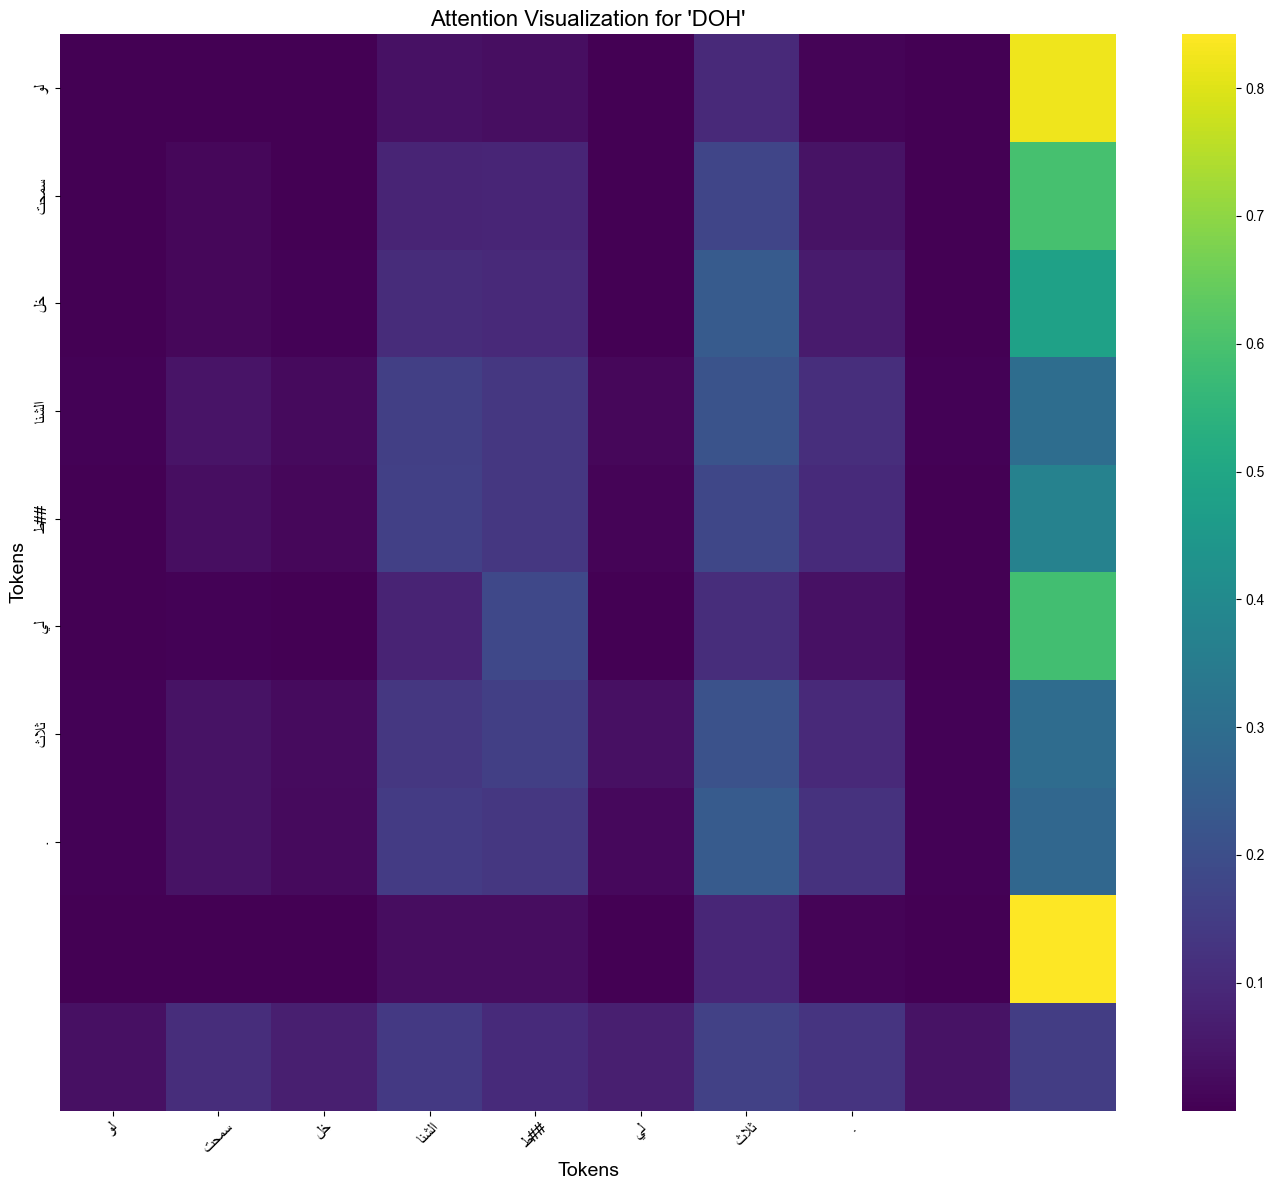


Attention visualization for Example 5:
Text: عندي اي شي شوي اطول؟
True dialect: BAS
Predicted dialect: BAS


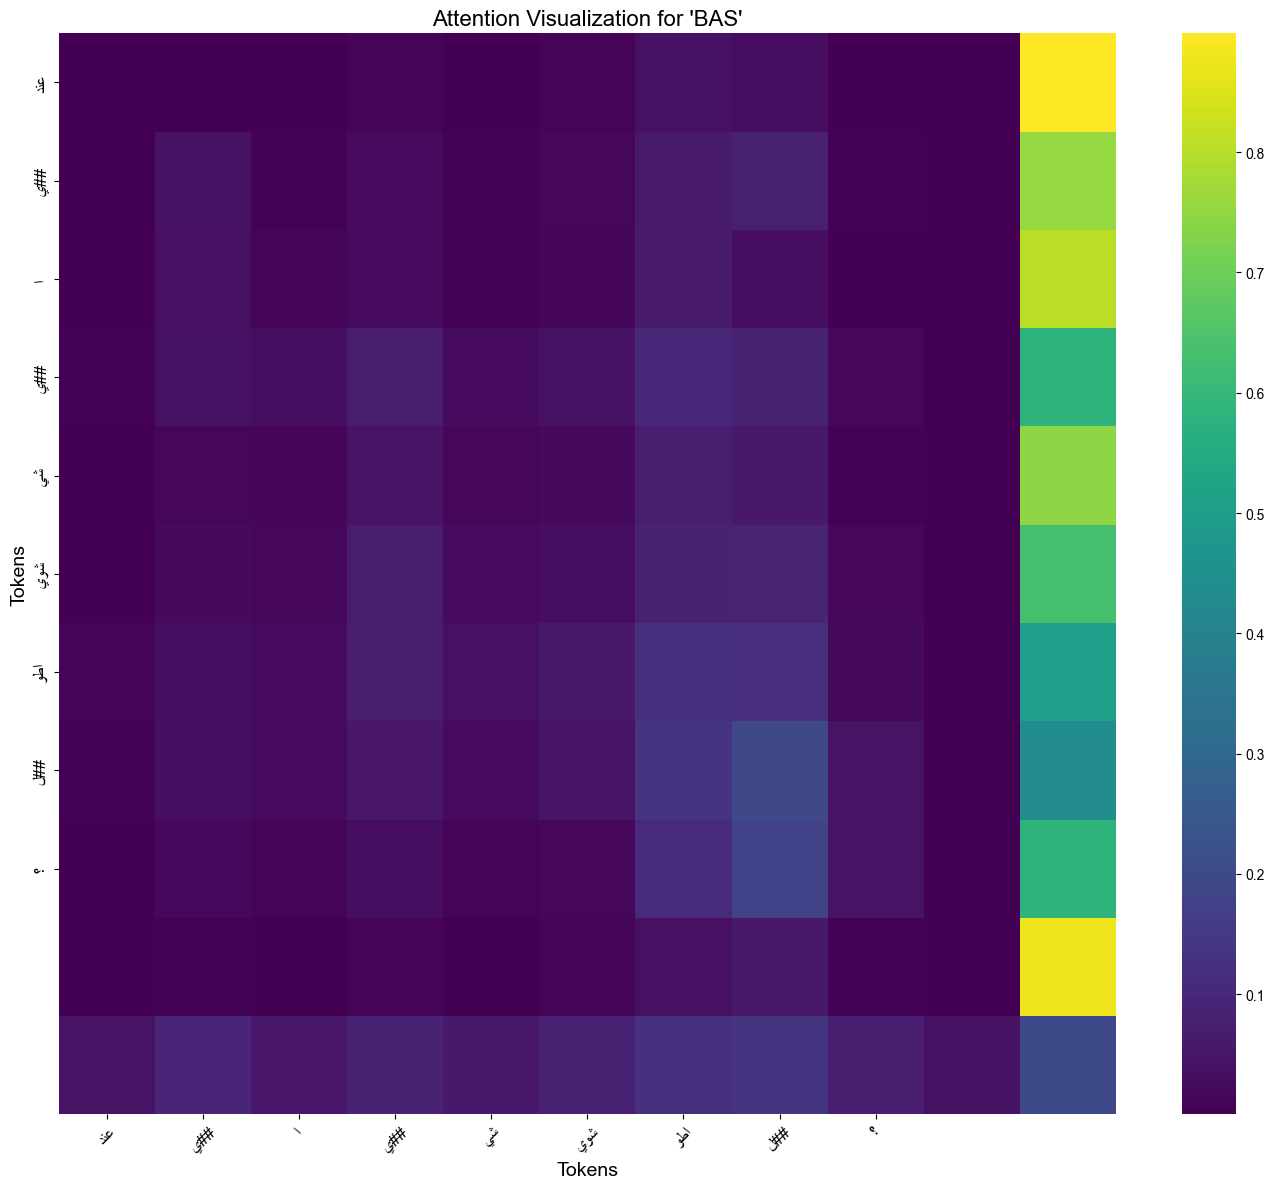

In [11]:
# Visualize attention for all samples
for i, (text, true_dialect, pred_dialect) in enumerate(zip(sample_texts, sample_true_dialects, sample_pred_dialects)):
    print(f"\nAttention visualization for Example {i+1}:")
    print(f"Text: {text}")
    print(f"True dialect: {true_dialect}")
    print(f"Predicted dialect: {pred_dialect}")
    
    # Get attention weights
    attention_weights = get_attention_weights(text)
    
    # Get tokens
    tokens = [tokenizer.convert_ids_to_tokens(id) for id in tokenizer.encode(text)][1:-1]  # Remove special tokens
    
    # Visualize attention from the last layer, last head
    last_layer_attn = attention_weights[-1][0].cpu().numpy()
    last_head_attn = last_layer_attn[-1]  # Last attention head
    
    # Plot attention heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(last_head_attn, xticklabels=[display_arabic(t) for t in tokens], 
                yticklabels=[display_arabic(t) for t in tokens], cmap='viridis', annot=False)
    plt.title(f"Attention Visualization for '{pred_dialect}'", fontsize=16)
    plt.xlabel("Tokens", fontsize=14)
    plt.ylabel("Tokens", fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

## 10. Conclusion

In this notebook, we've loaded a pre-trained Arabic dialect classification model and used explainable AI techniques (LIME, Attention Visualization, and a SHAP-like approach) to understand the model's predictions. These explanations help us identify which parts of the text are most important for classifying Arabic dialects.